In [18]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import optim
from torch.utils.data import DataLoader

import matplotlib.animation as animation
from IPython.display import HTML

from tqdm import tqdm
from geomloss import SamplesLoss

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from contrib.handcrafted_data import syn_dataset
from vectran.data.graphics_primitives import PrimitiveType
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineBatchRandomShift, torch_to_synthetic_lines
)

from stateful_batch_aligner import (
    StatefulBatchAligner, 
    LossComposition, 
    init_ot_aligner,
    make_default_loss_fn,
    make_default_optimize_fn,
    store_render_difference,
    strip_confidence_grads,
#     save_best_batch
)
from crossing_refiner import CrossingRefinerFull

DEVICE = 'cuda:1'

In [19]:
def compose(*fns):
    def composition(state):
        result = None
        for fn in fns:
            result = fn(state)
        return result    
            
    return composition


def coords_only_grads(n_steps=200):
    def fn(state):
        if state['current_step'] < n_steps:
            state['current_line_batch'].grad.data[:, :, 4] = 0.
    return fn


def reduced_width_lr(multiplier=0.2):
    def fn(state):
        state['current_line_batch'].grad.data[:, :, 4] *= multiplier
    return fn


def not_too_thin(state):
    return torch.sum(torch.relu(1. - state['current_line_batch'][:, :, 4]))


def perceptual_bce(model, n_convolutions=2, weight=1.0):
    bce = torch.nn.BCEWithLogitsLoss(reduction='none')
    def fn(state):
        render = model.apply_convolutions(state['render'].unsqueeze(1), n_convolutions)
        raster = model.apply_convolutions(state['raster'].unsqueeze(1), n_convolutions)
        result = weight * bce(render, raster).mean(dim=(1, 2, 3)).sum()
        return result
    
    return fn


def accumulate_renders(state):
    if 'renders' not in state:
        state['renders'] = []
    state['renders'].append(state['render'][0].detach().cpu().numpy())

In [20]:
model = CrossingRefinerFull().to(DEVICE)
model.load_state_dict(torch.load('best_crossings_good_backup.pt'))
_ = model.train(False)

In [21]:
np.random.seed(4)
torch.manual_seed(4)

dataloader = DataLoader(syn_dataset, batch_size=32)

perturber = LinePerturbationPipe(
    LineBatchRandomShift((-6, 6), (0, 1)),
)

n_steps = 300

loss = LossComposition()
ot_loss = SamplesLoss("sinkhorn", p=2, blur=.05, scaling=.6, reach=6.)
loss.add(make_default_loss_fn(bce_schedule=(lambda state: 0.0), ot_loss=ot_loss))
loss.add(not_too_thin)
loss.add(perceptual_bce(model, 2))
# loss.add(perceptual_bce(model, 4))

aligner = None

for i, batch in enumerate(dataloader):
    vectors = perturber.transform(batch['vector'][PrimitiveType.PT_LINE].type(torch.float32)).to(DEVICE)
    vectors[:, :, 5] = 0.5
    
    rasters = 1. - batch['raster'].to(DEVICE)
    rasters = model.forward(rasters.unsqueeze(1)).squeeze(1).detach()
    rasters /= rasters.max(dim=2, keepdim=True).values.max(dim=1, keepdim=True).values
    
    grad_transformer = compose(strip_confidence_grads, coords_only_grads(n_steps - 100))
    
    aligner = StatefulBatchAligner(vectors, rasters, device=DEVICE)
    init_ot_aligner(aligner, loss_fn=loss, device=DEVICE,
                    optimize_fn=make_default_optimize_fn(
                        aligner, 
                        lr=0.25, 
                        transform_grads=grad_transformer,
                        base_optimizer=optim.Adam,
                    ))
    
    aligner.add_callback(store_render_difference)
    aligner.add_callback(accumulate_renders)
    
    for _ in tqdm(range(n_steps)):
        aligner.step()
    
    if i == 0:
        break

  2%|▏         | 5/300 [00:03<03:00,  1.63it/s]


KeyboardInterrupt: 

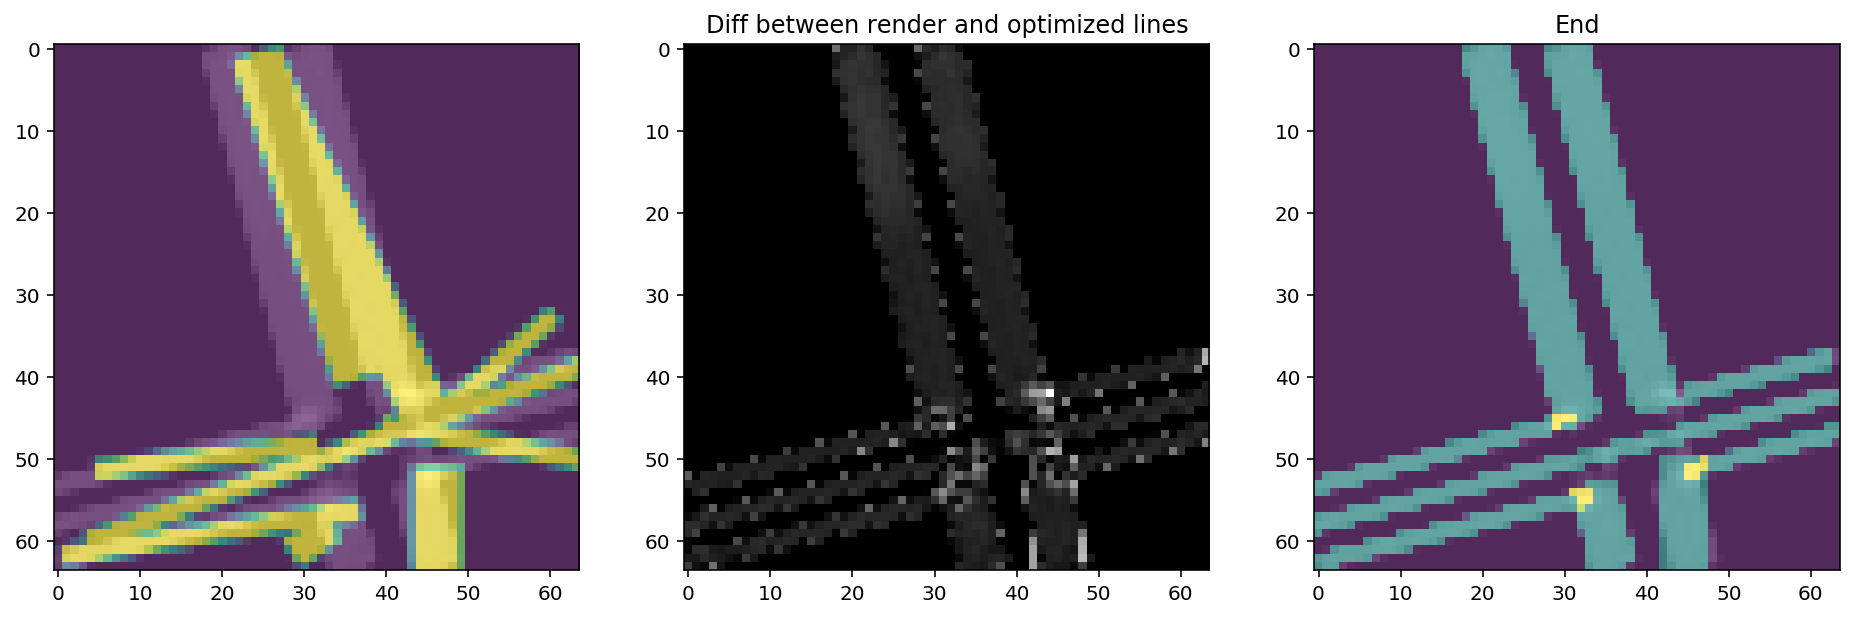

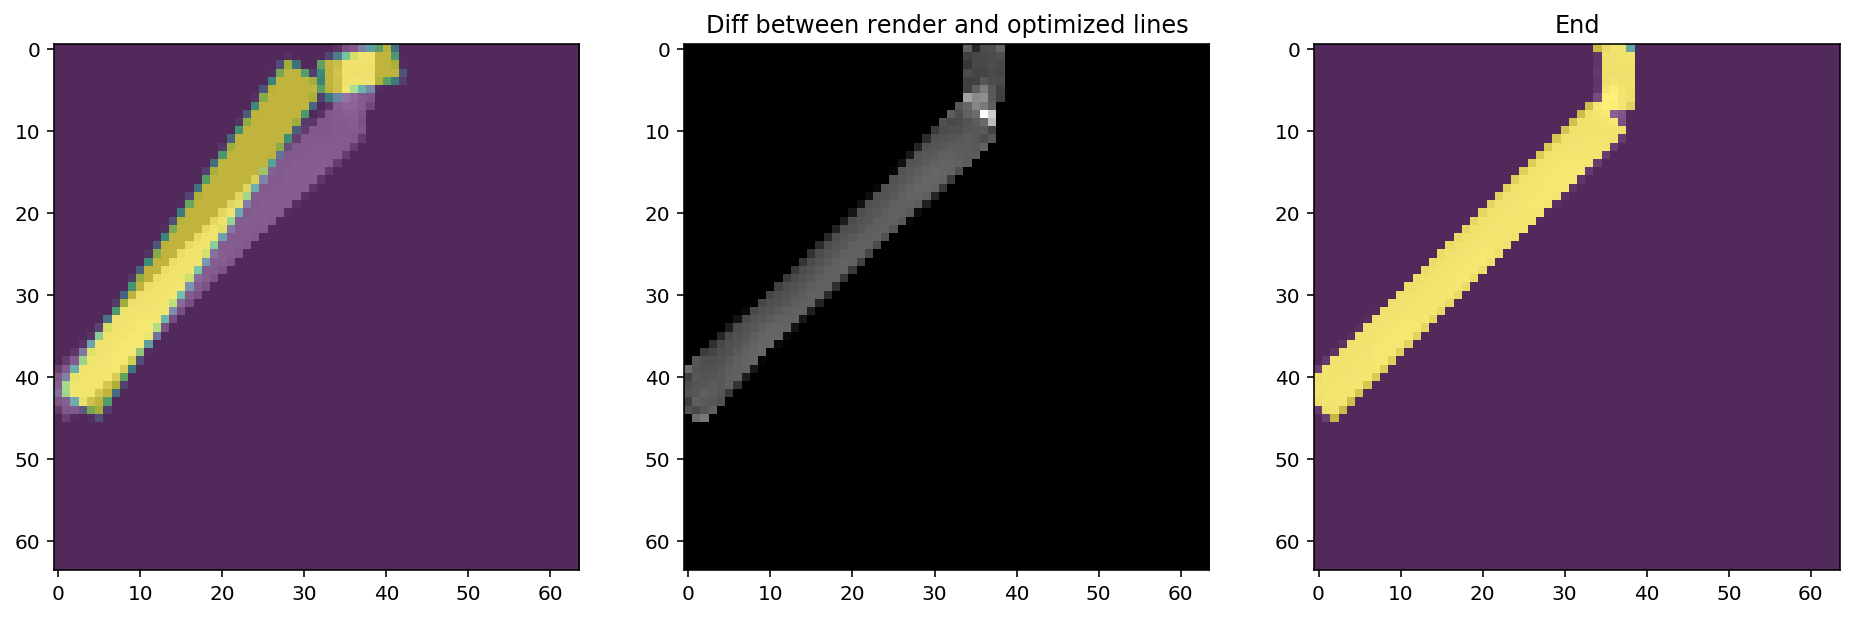

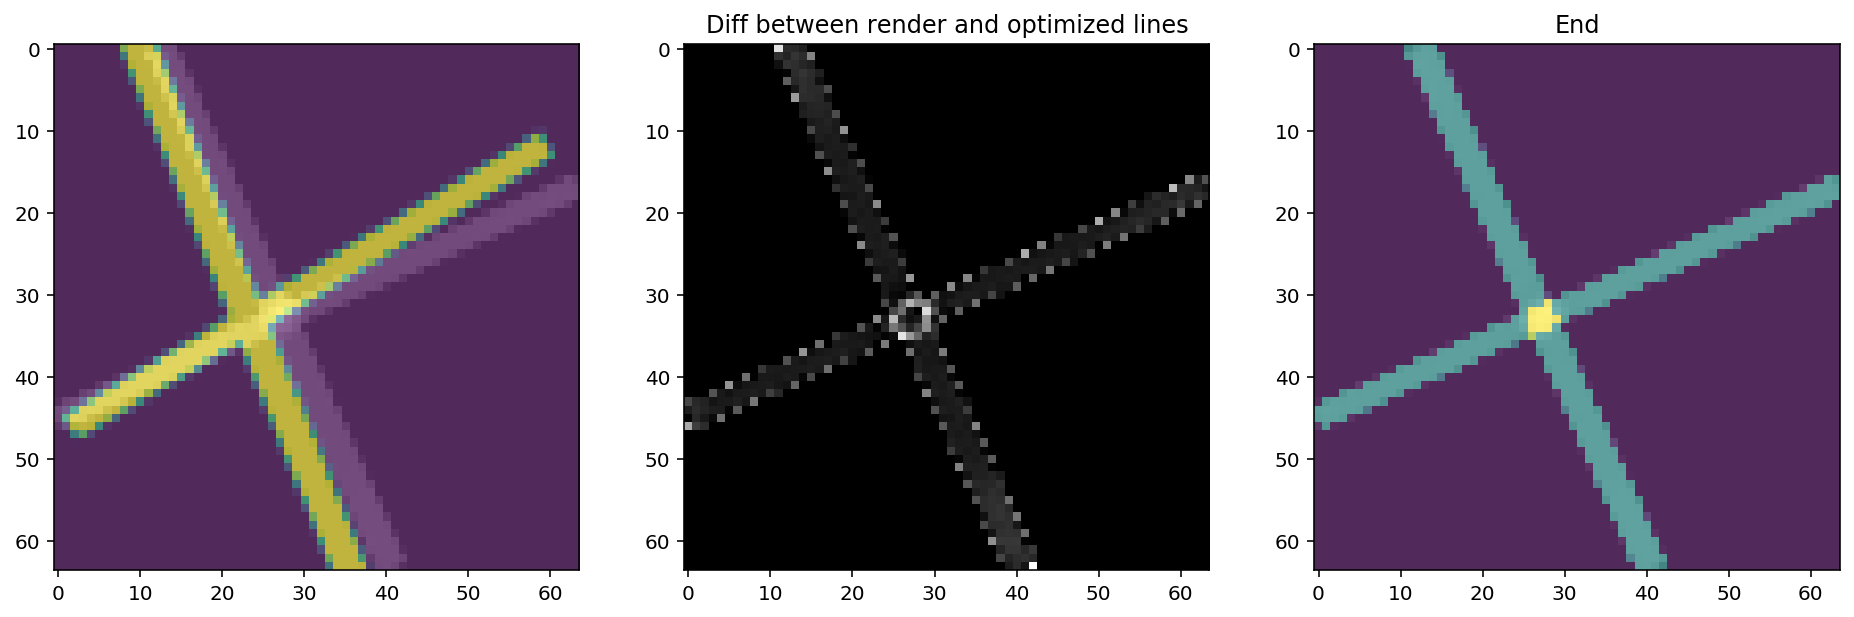

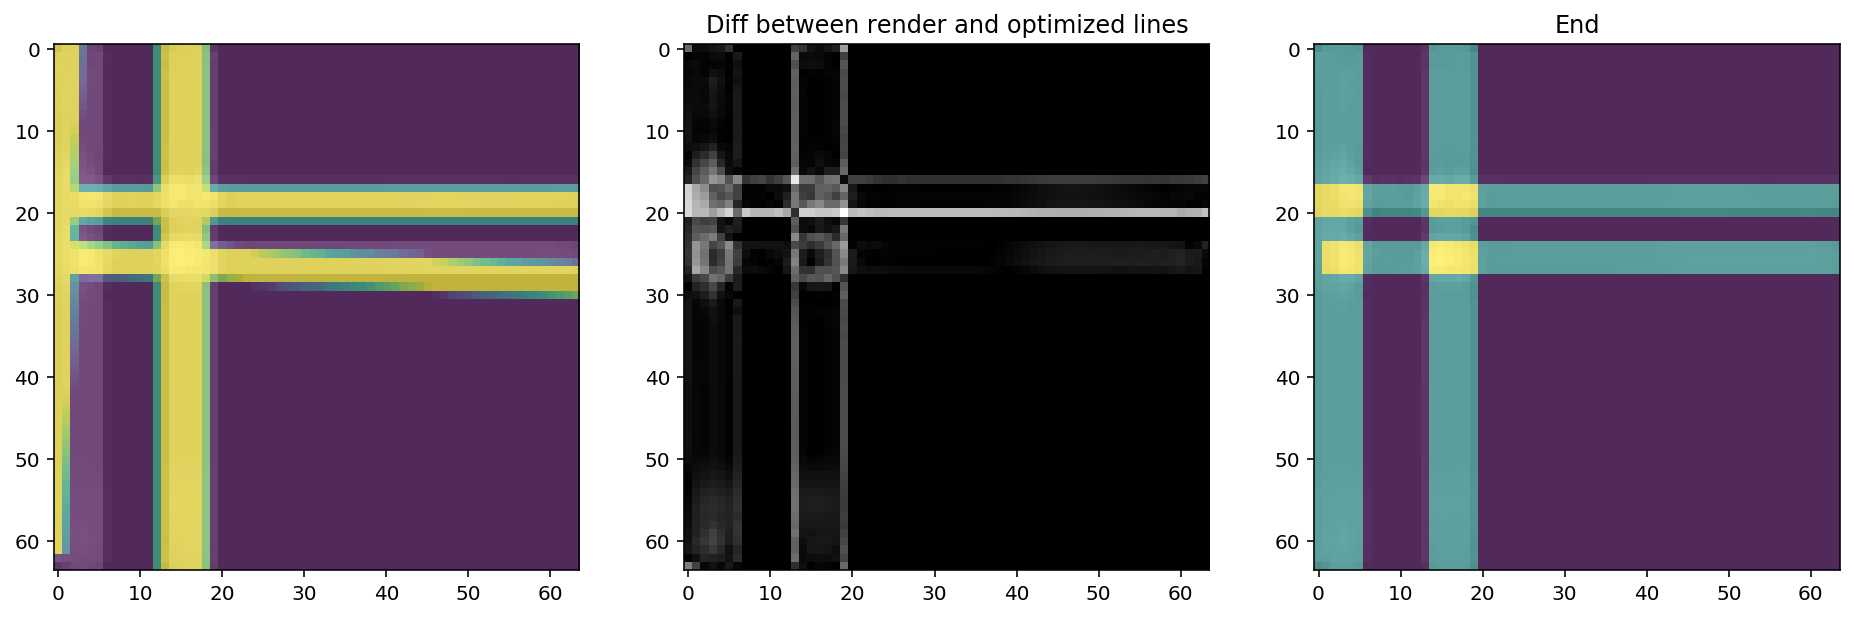

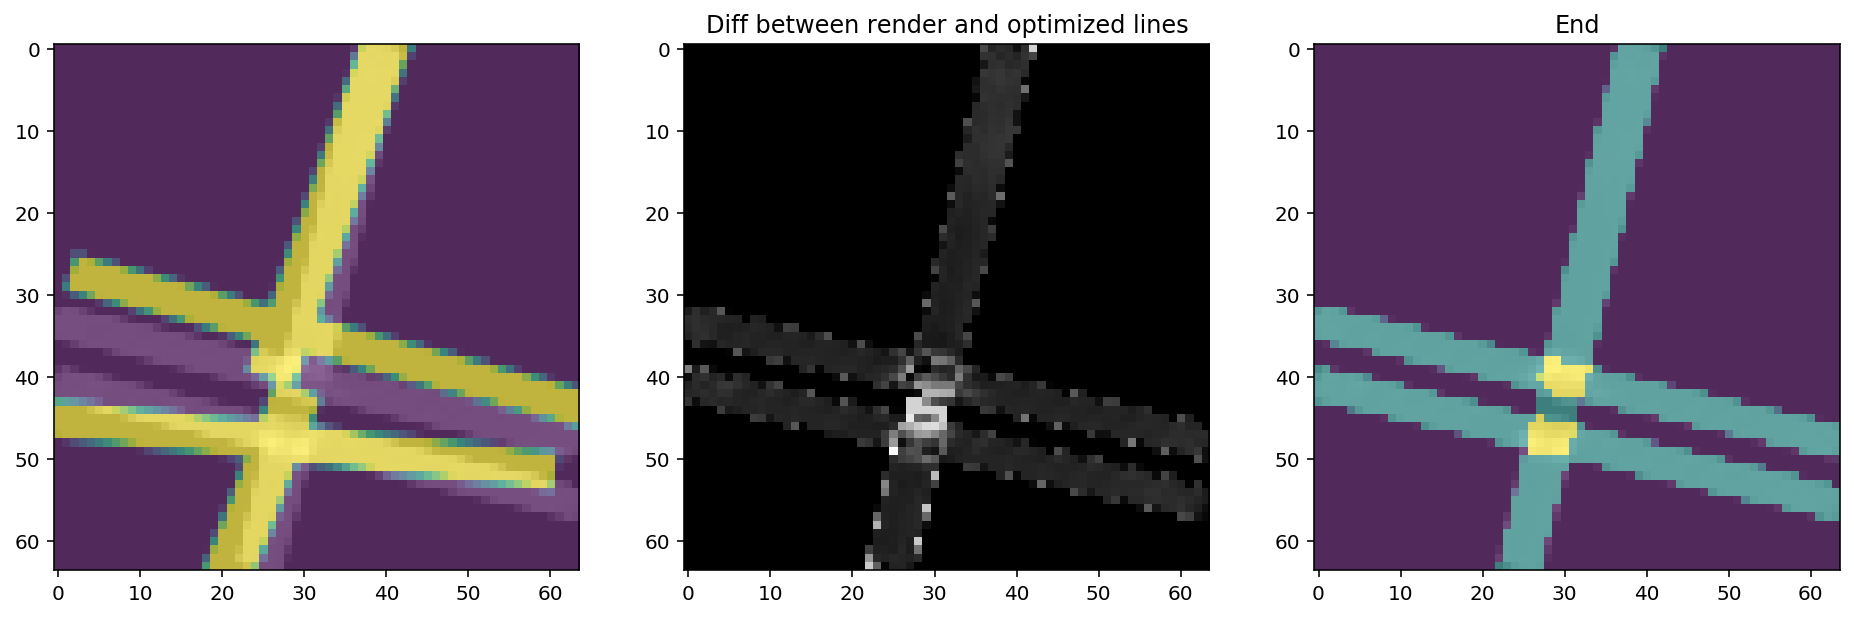

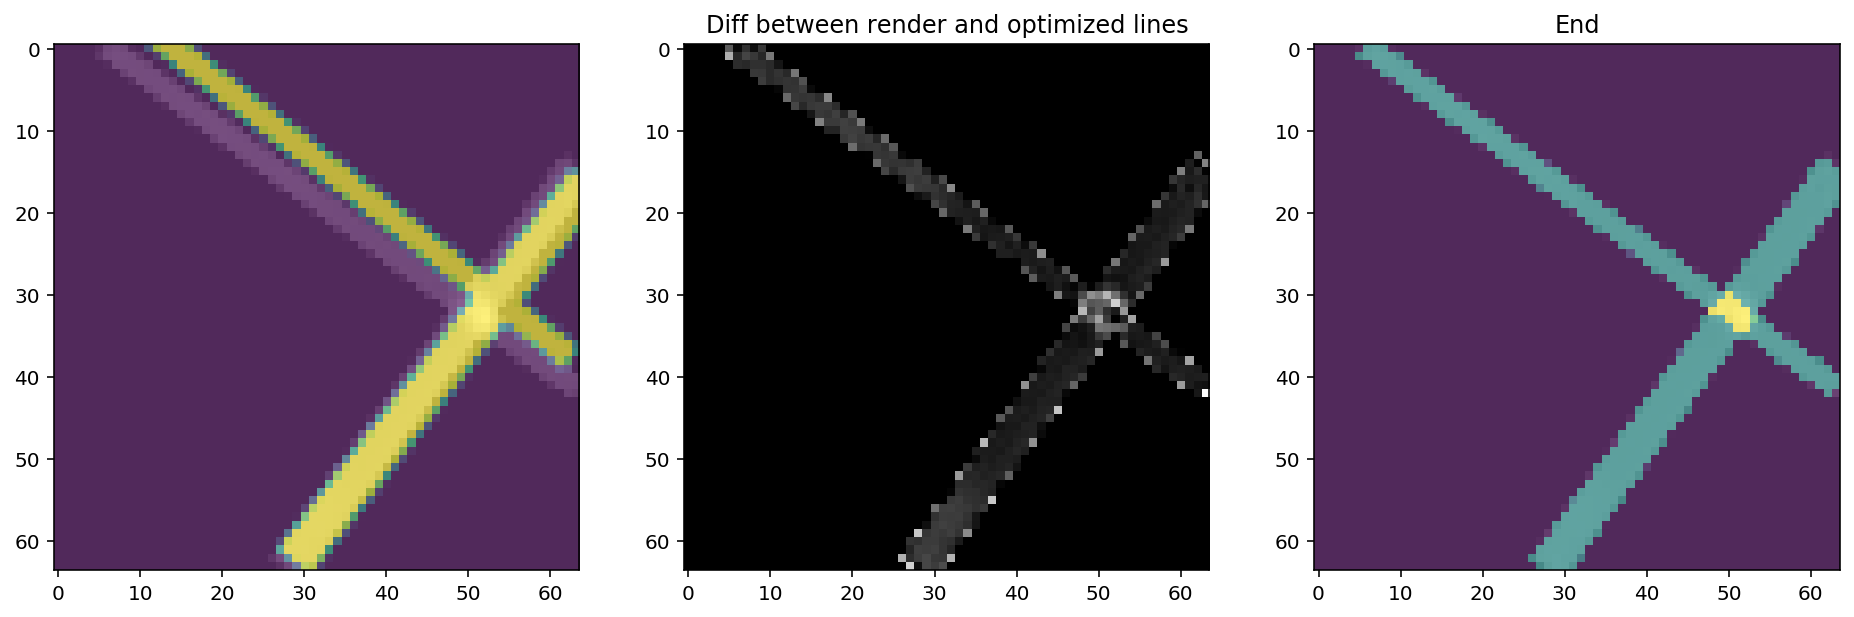

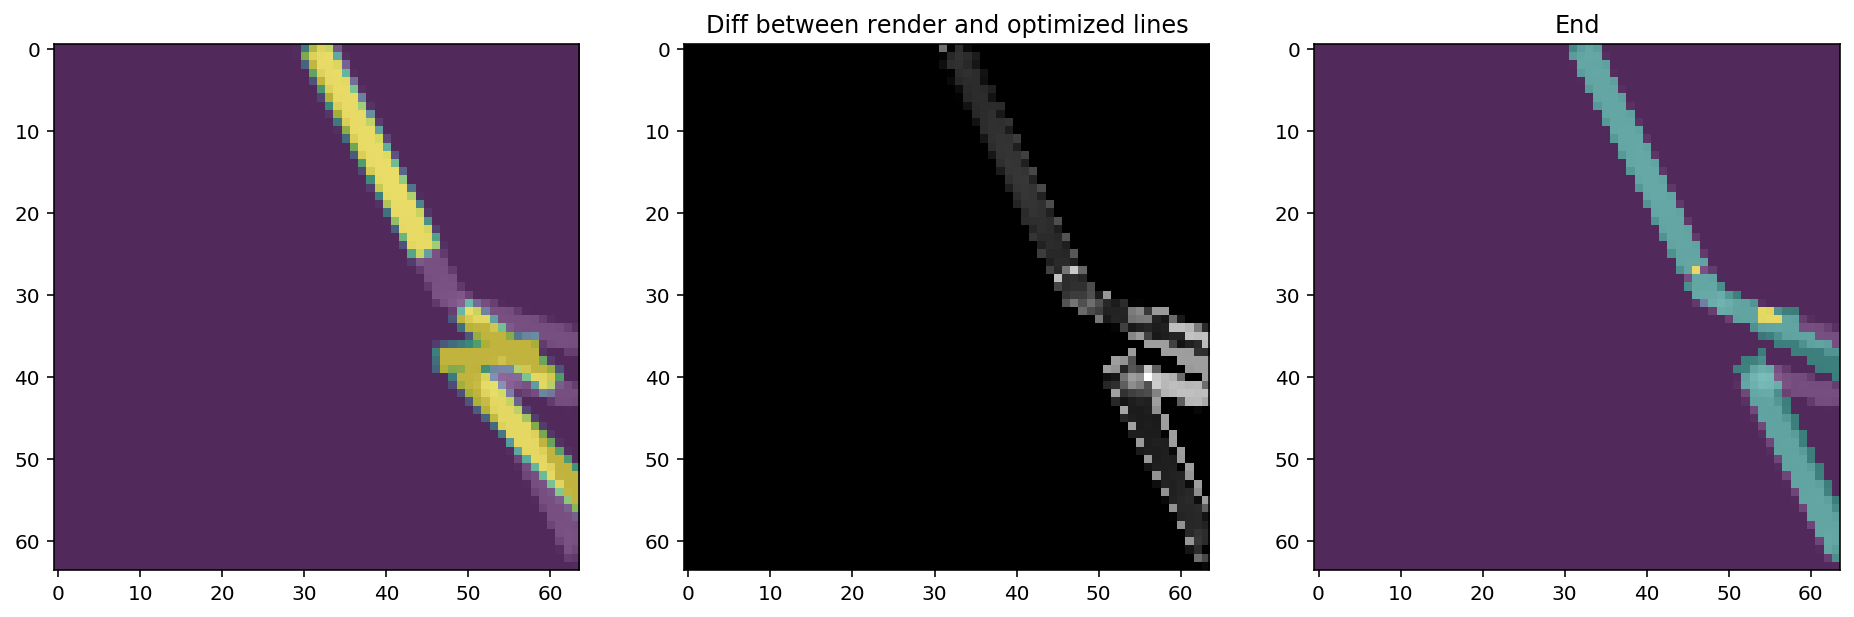

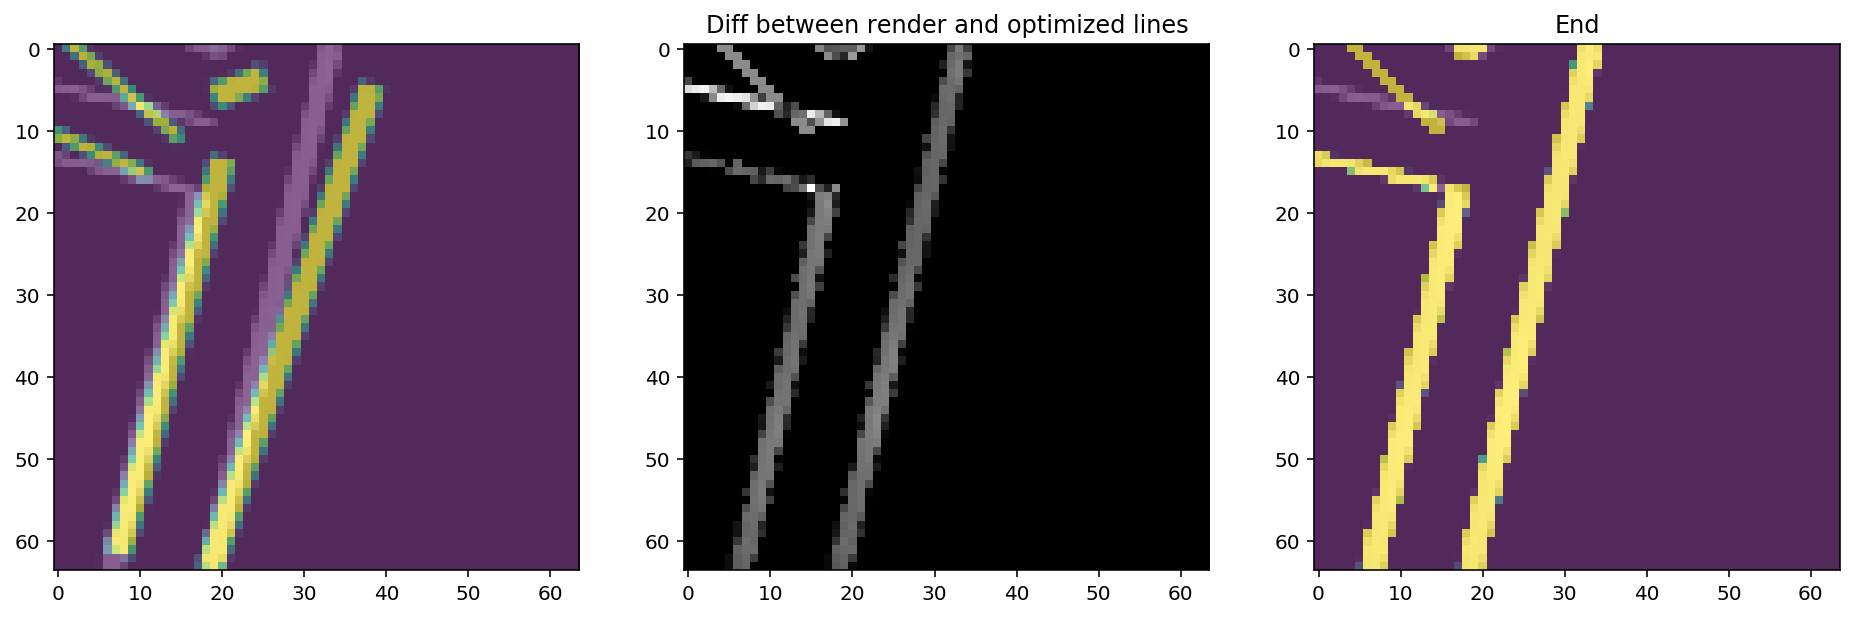

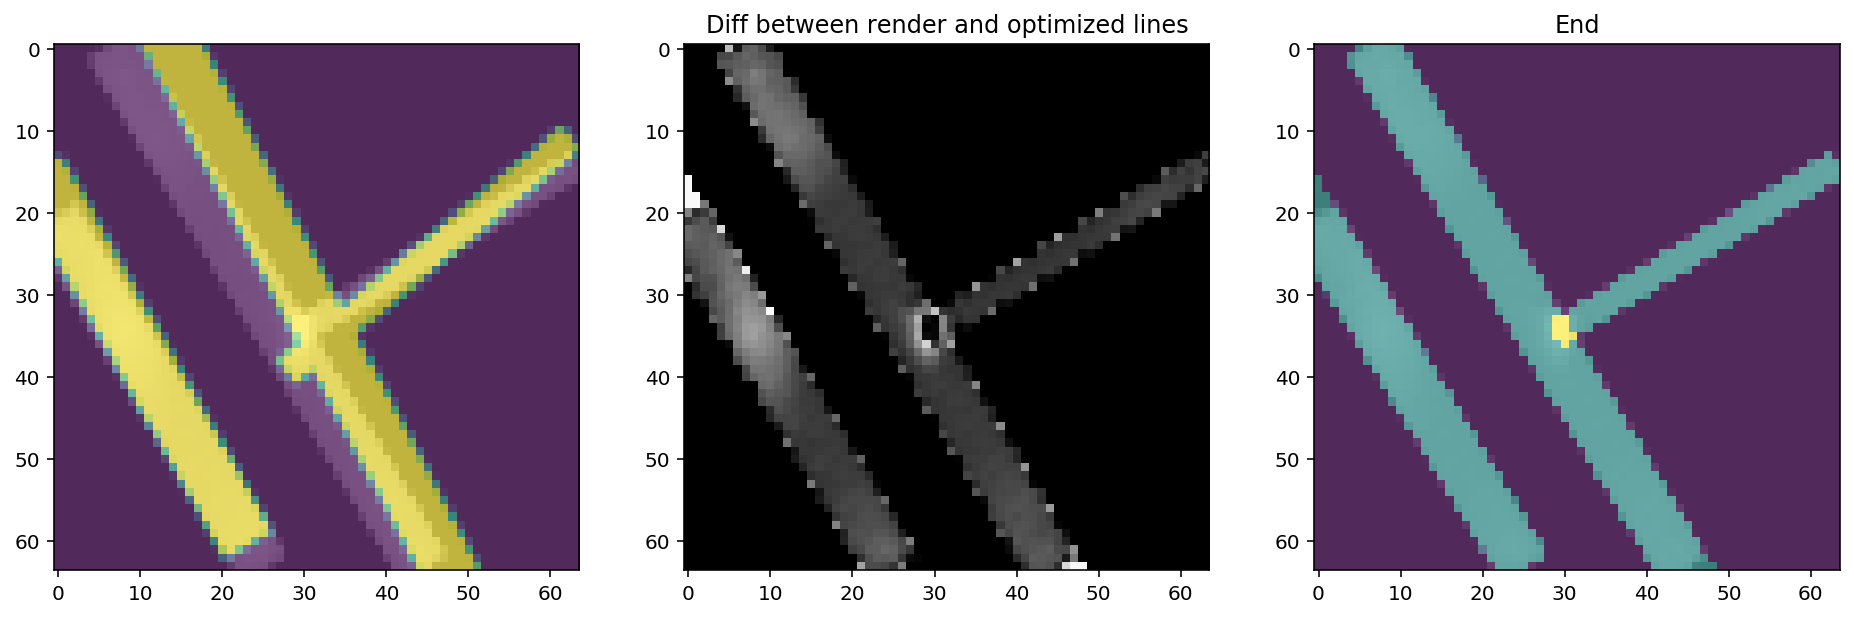

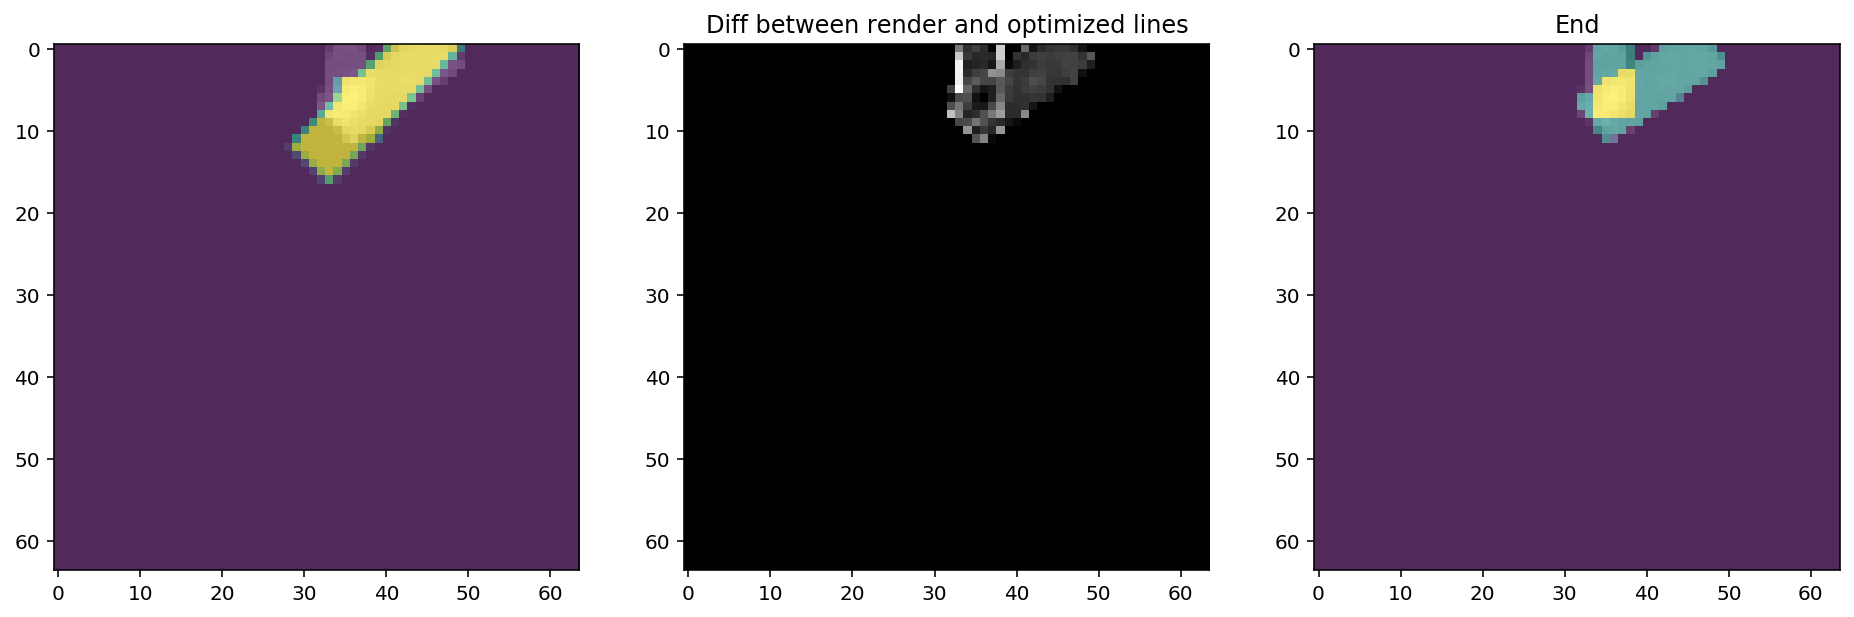

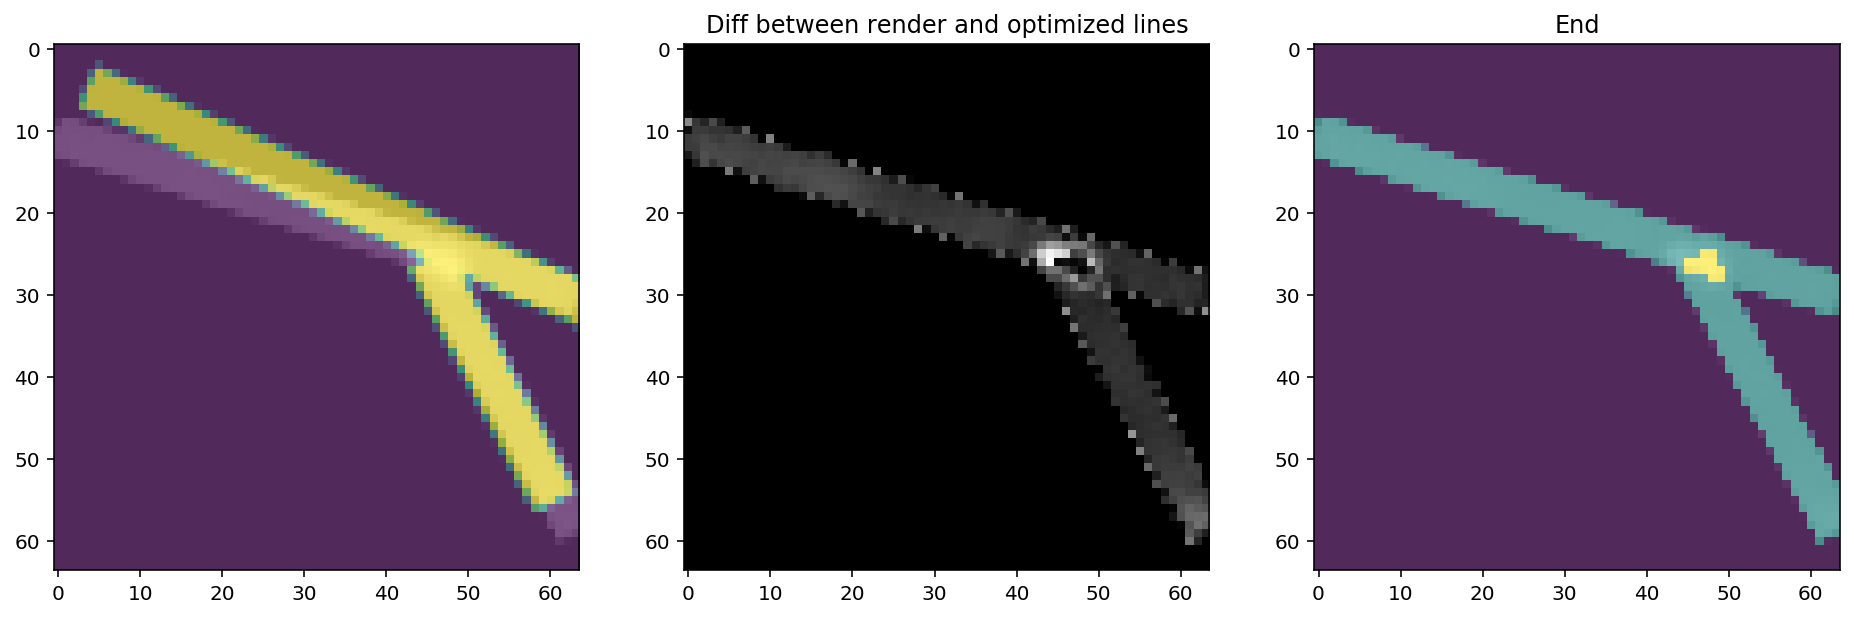

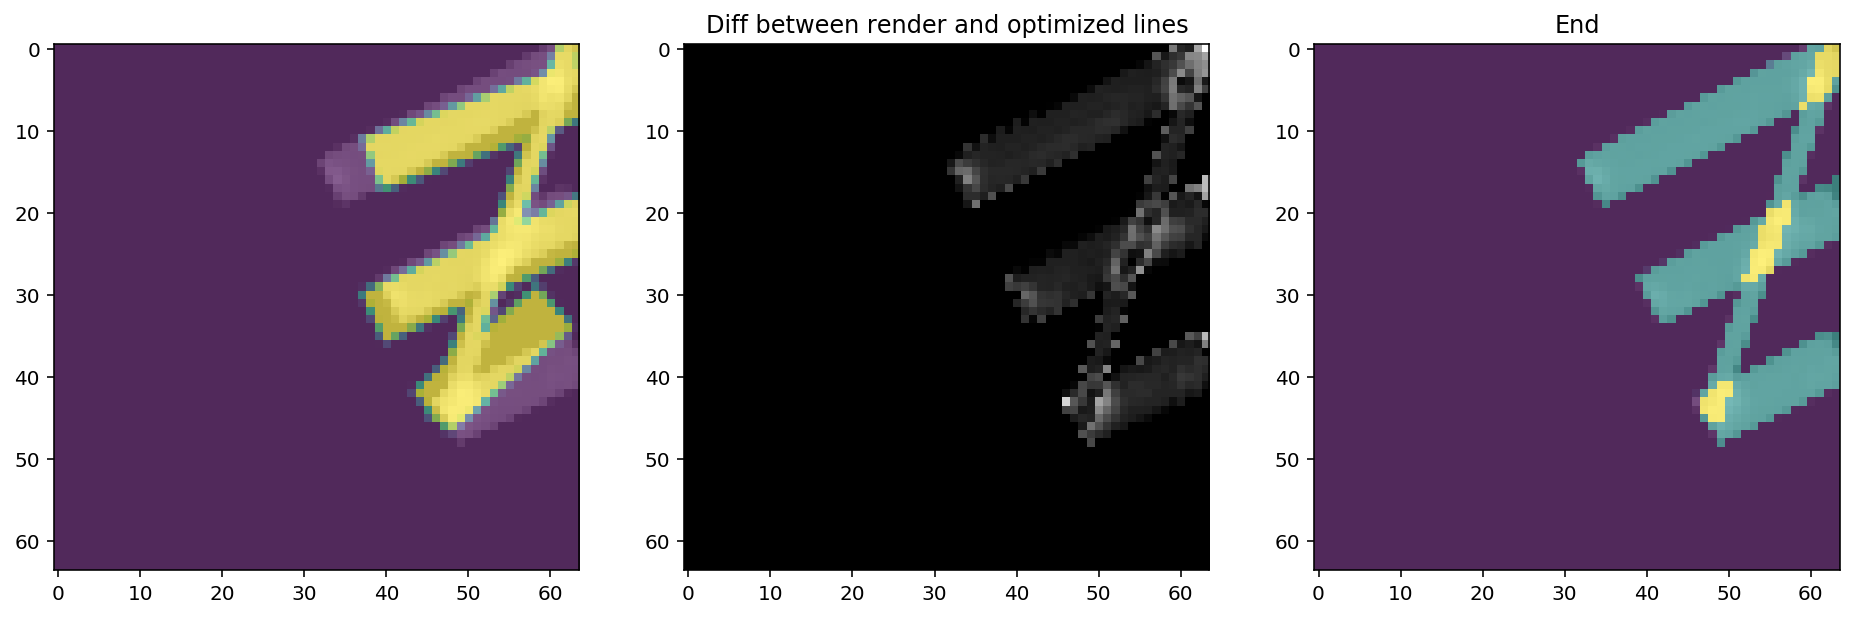

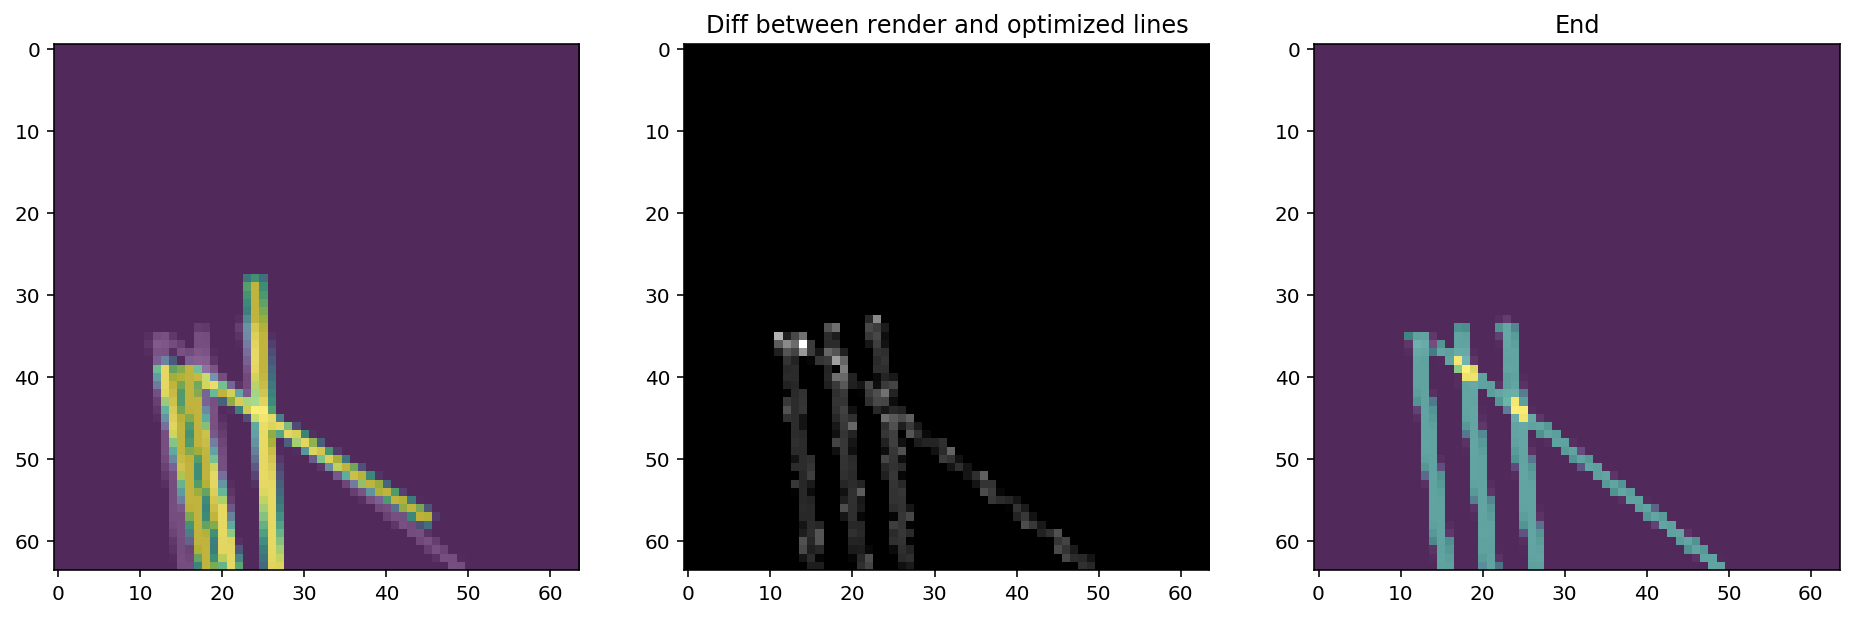

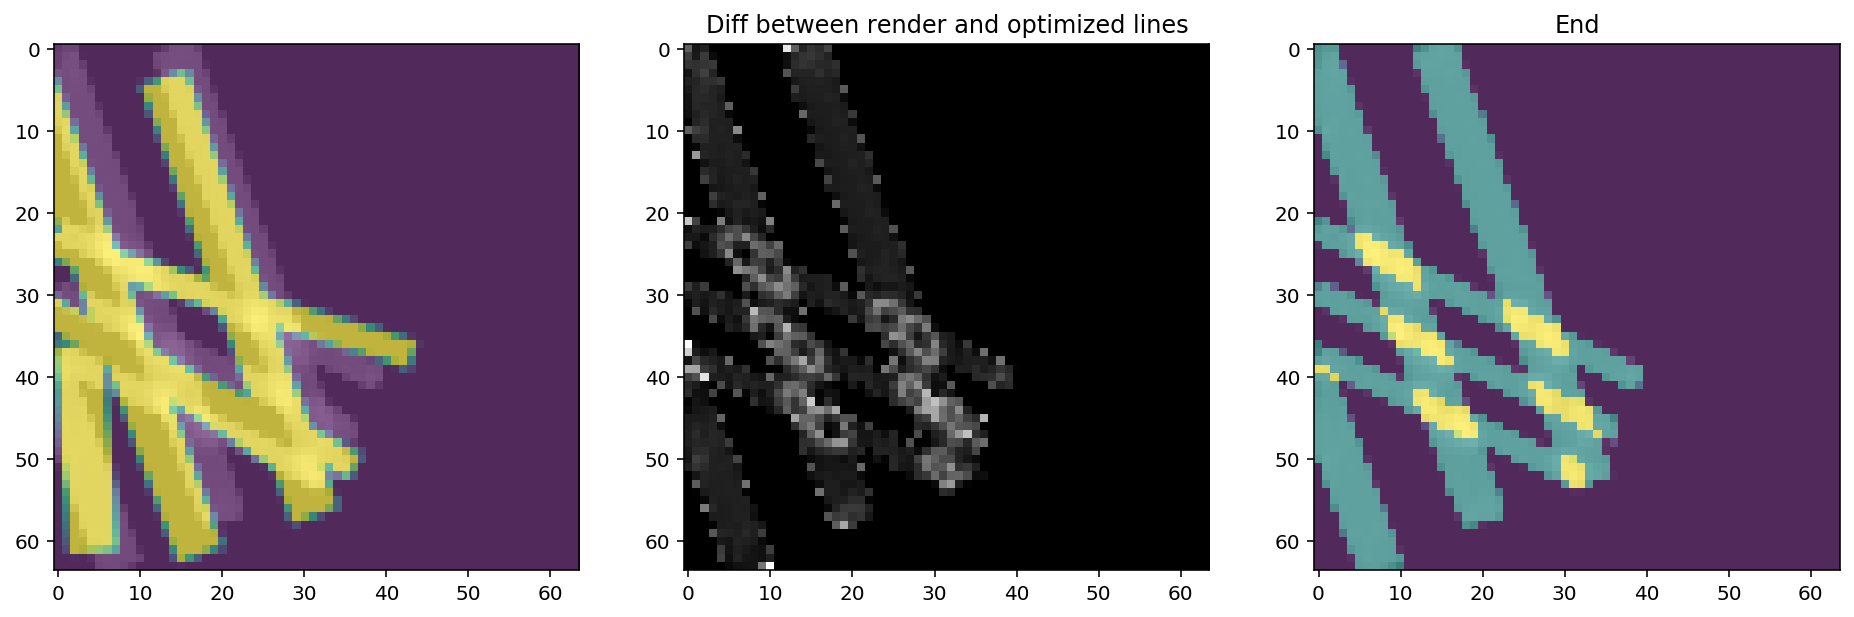

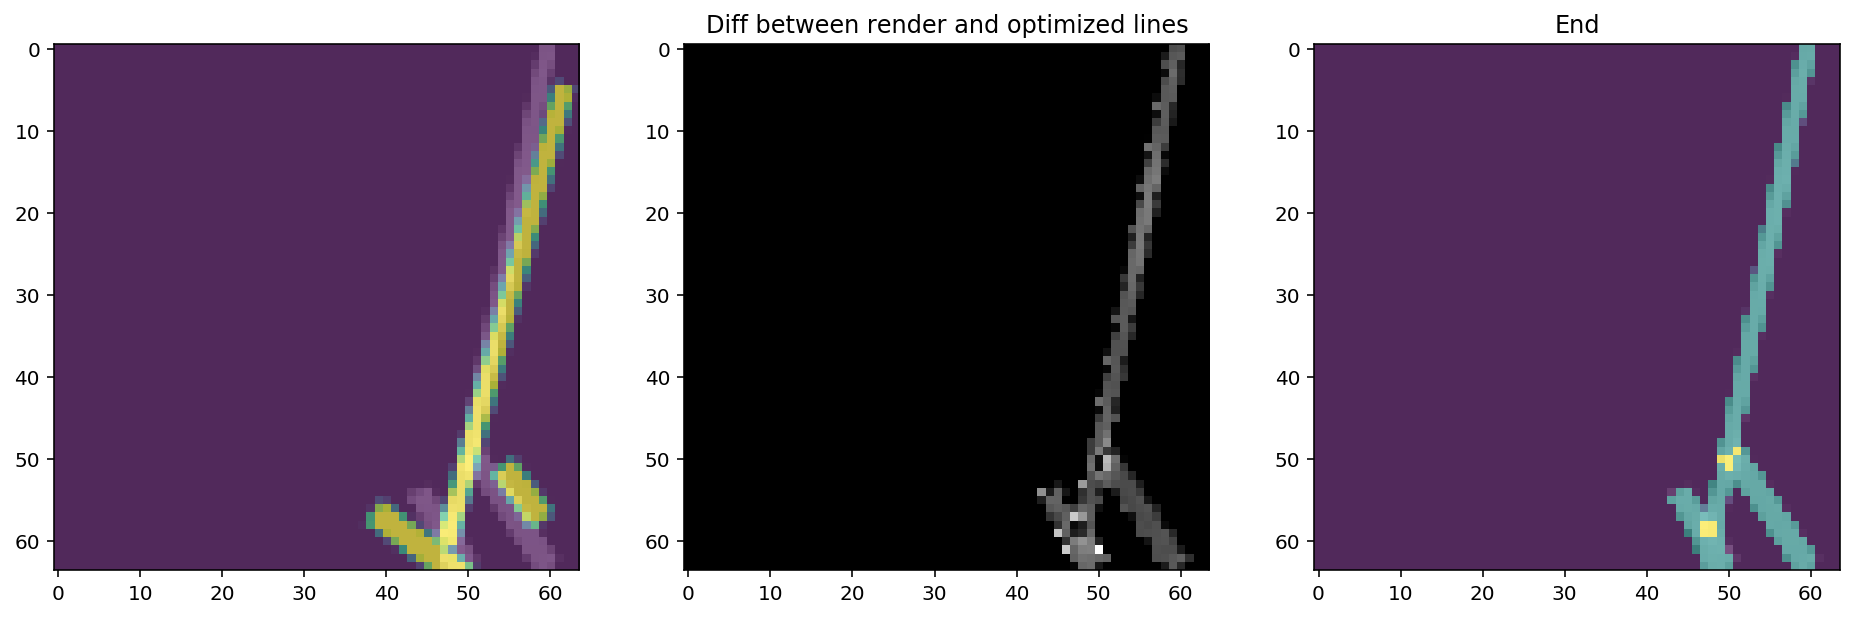

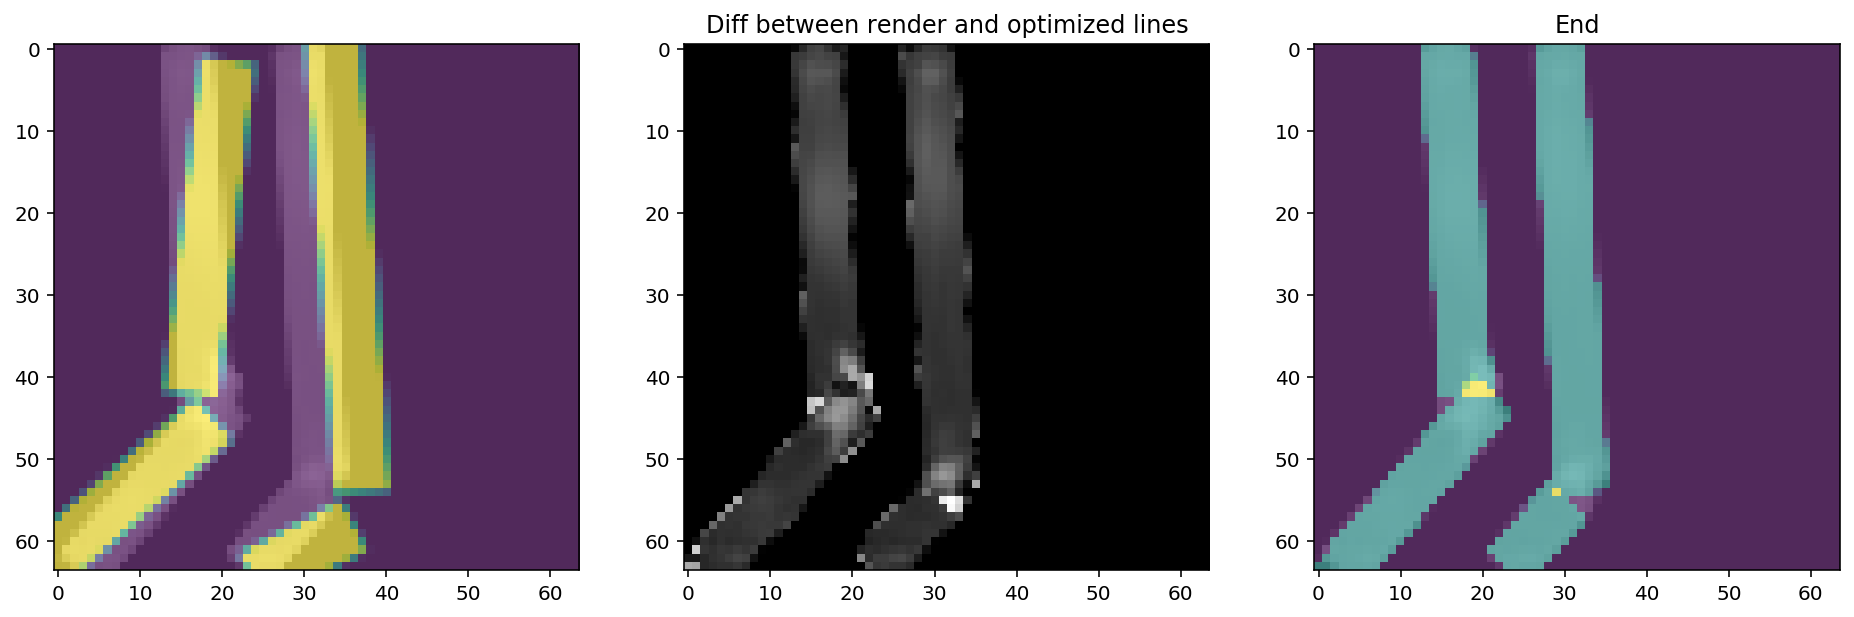

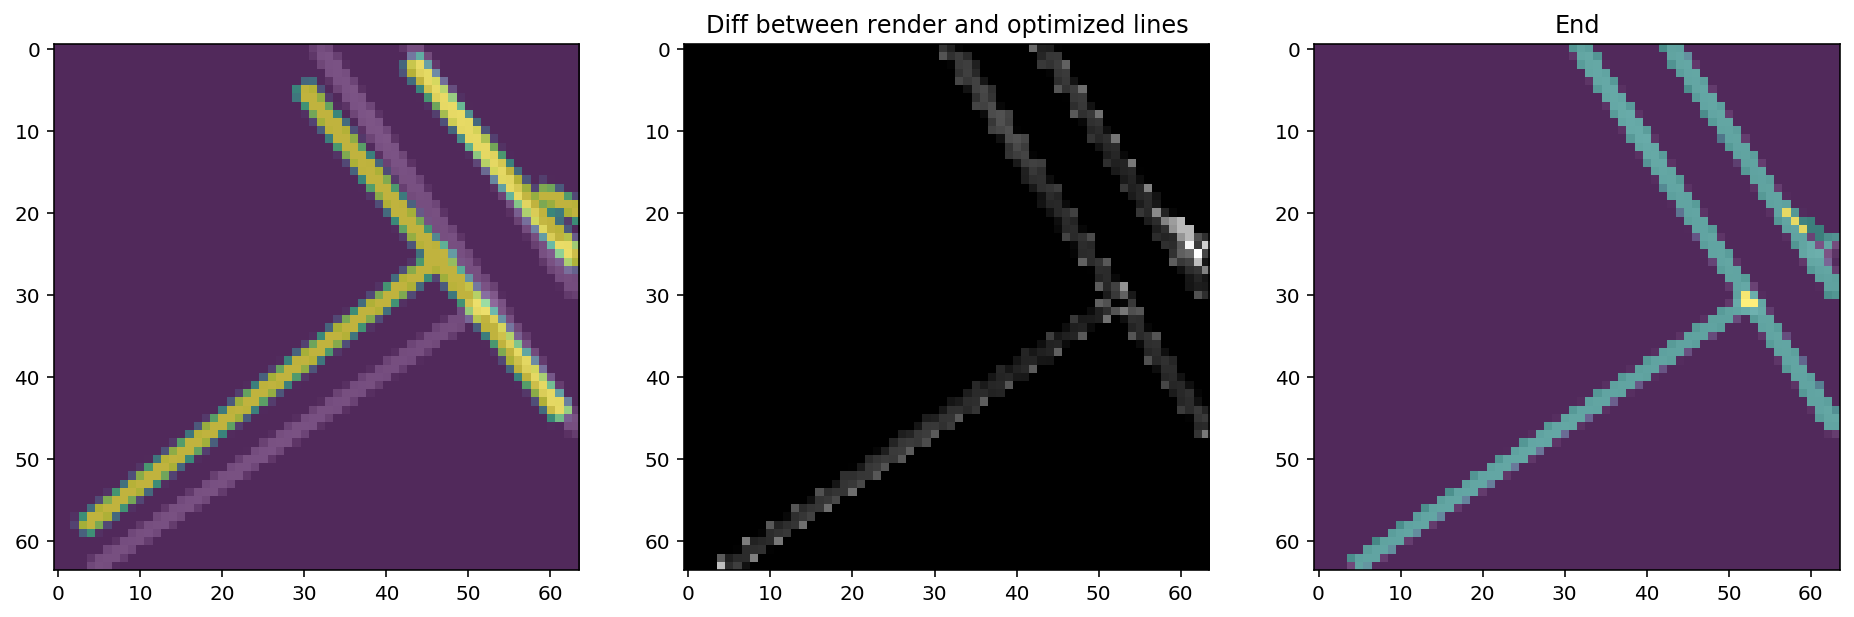

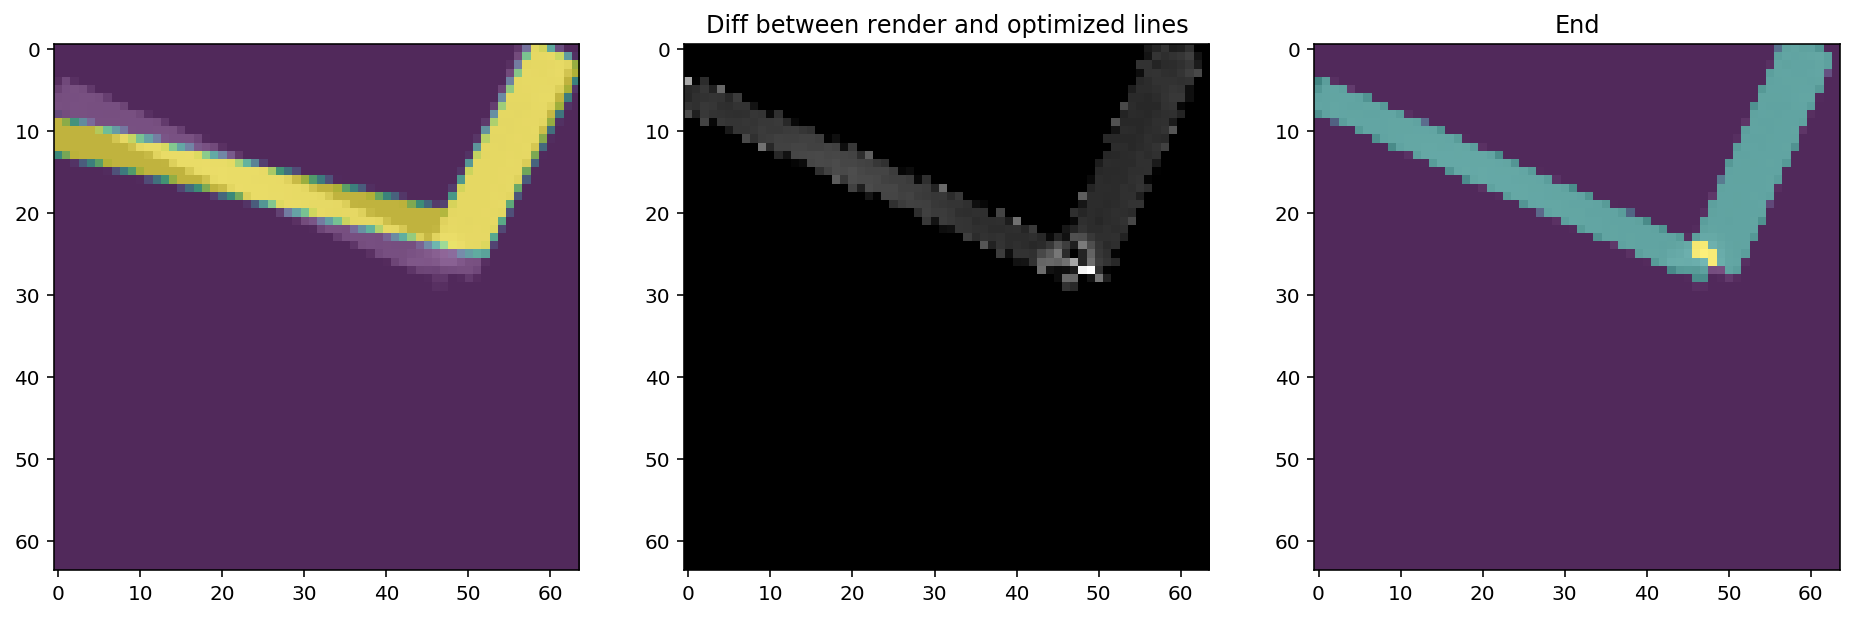

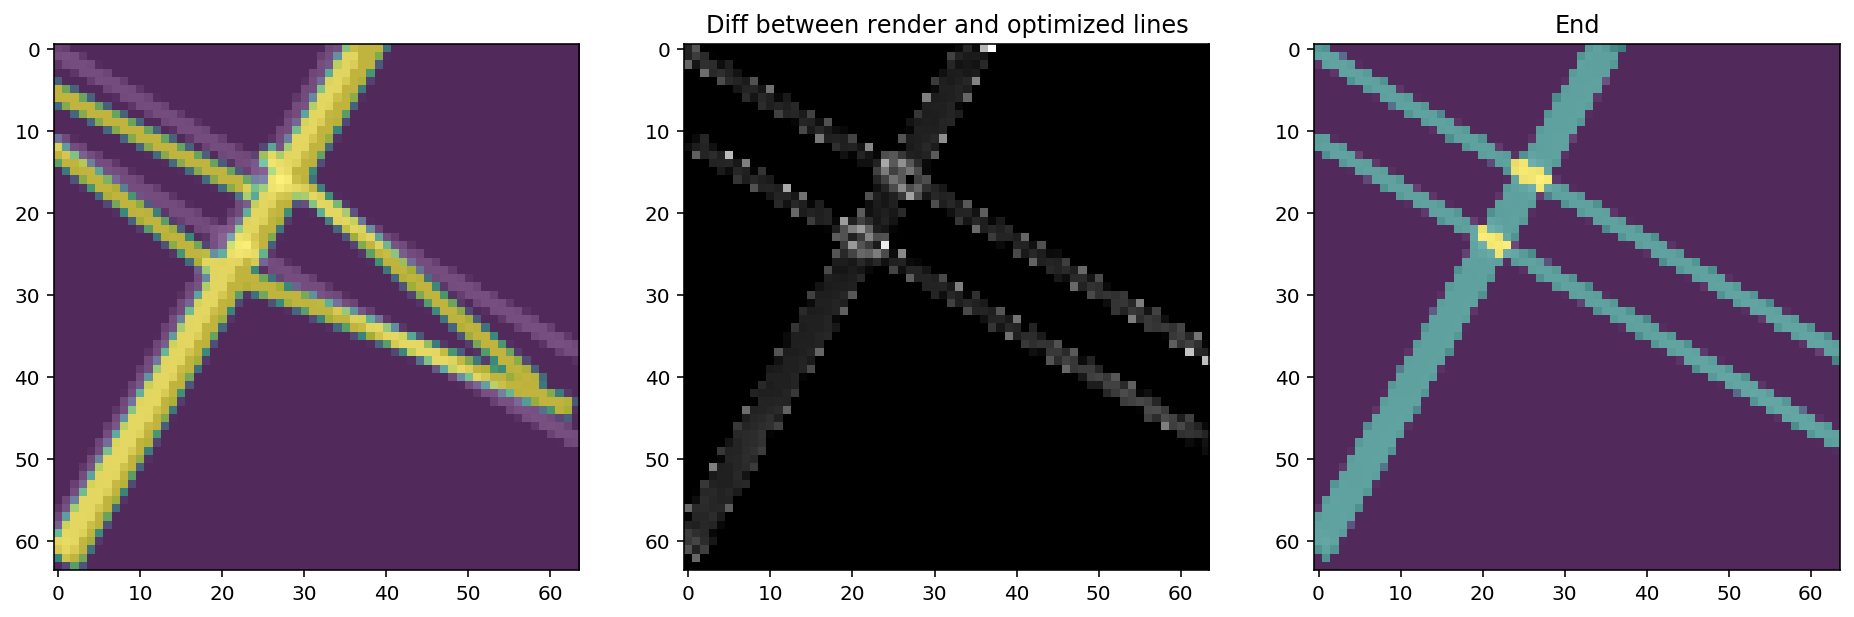

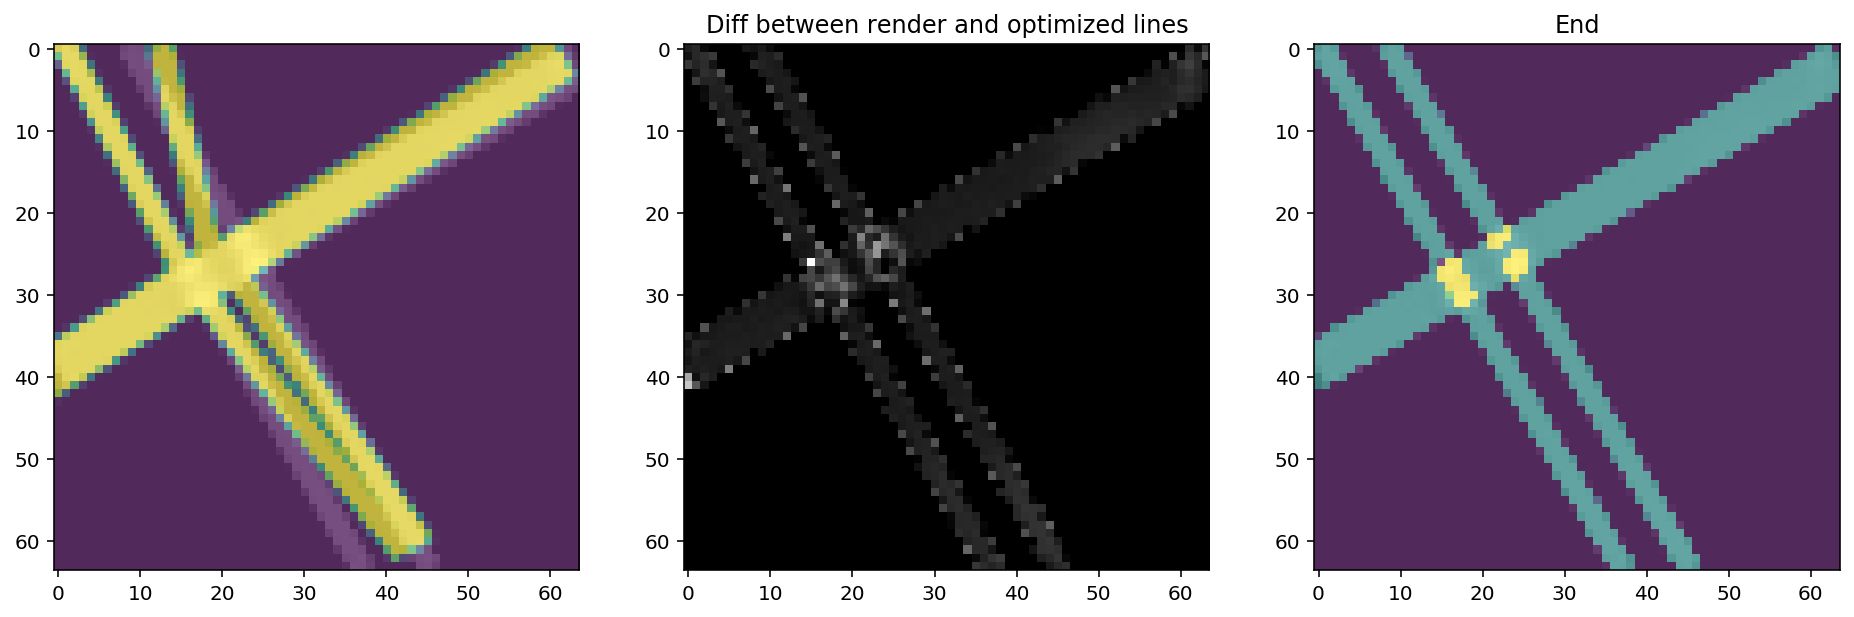

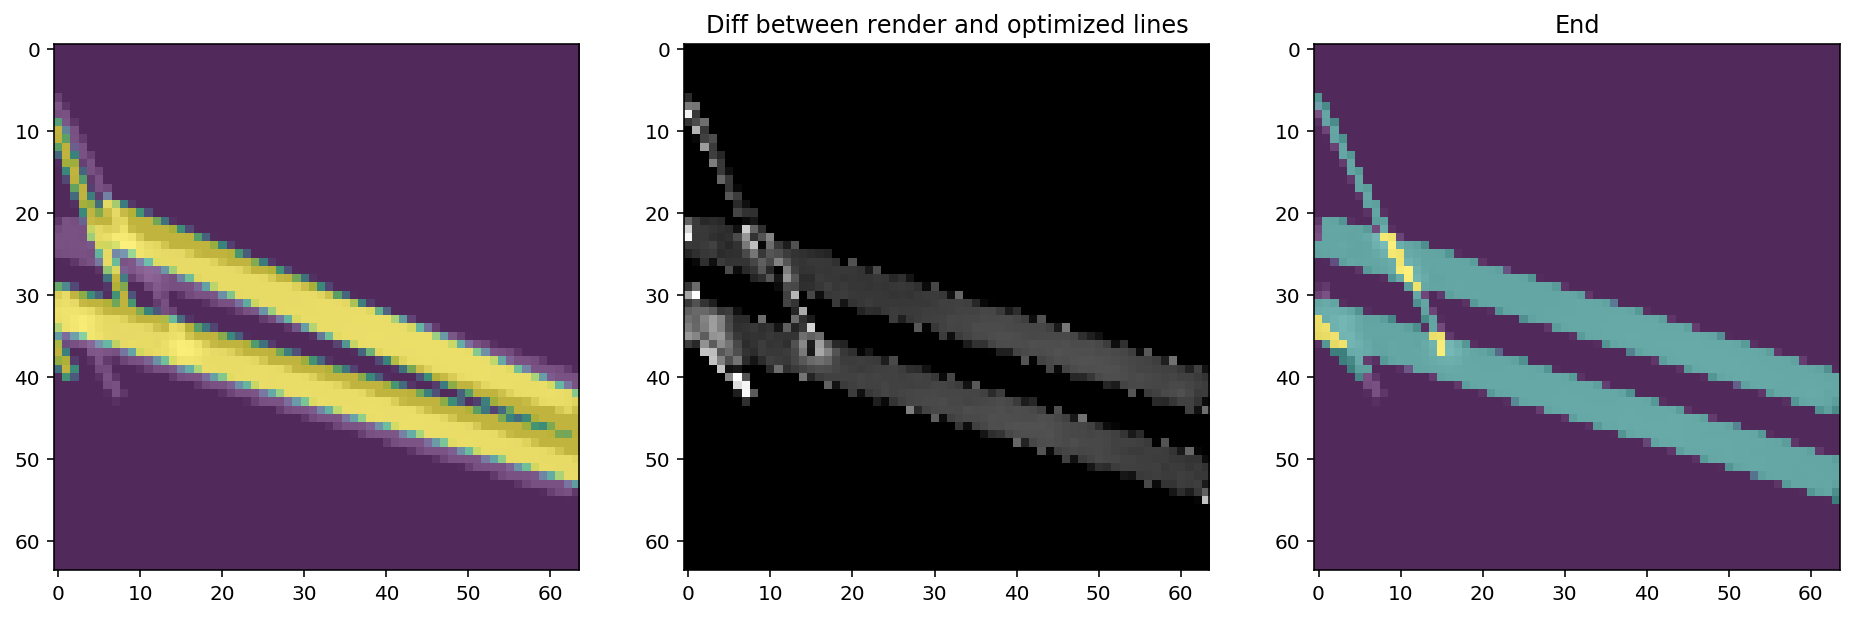

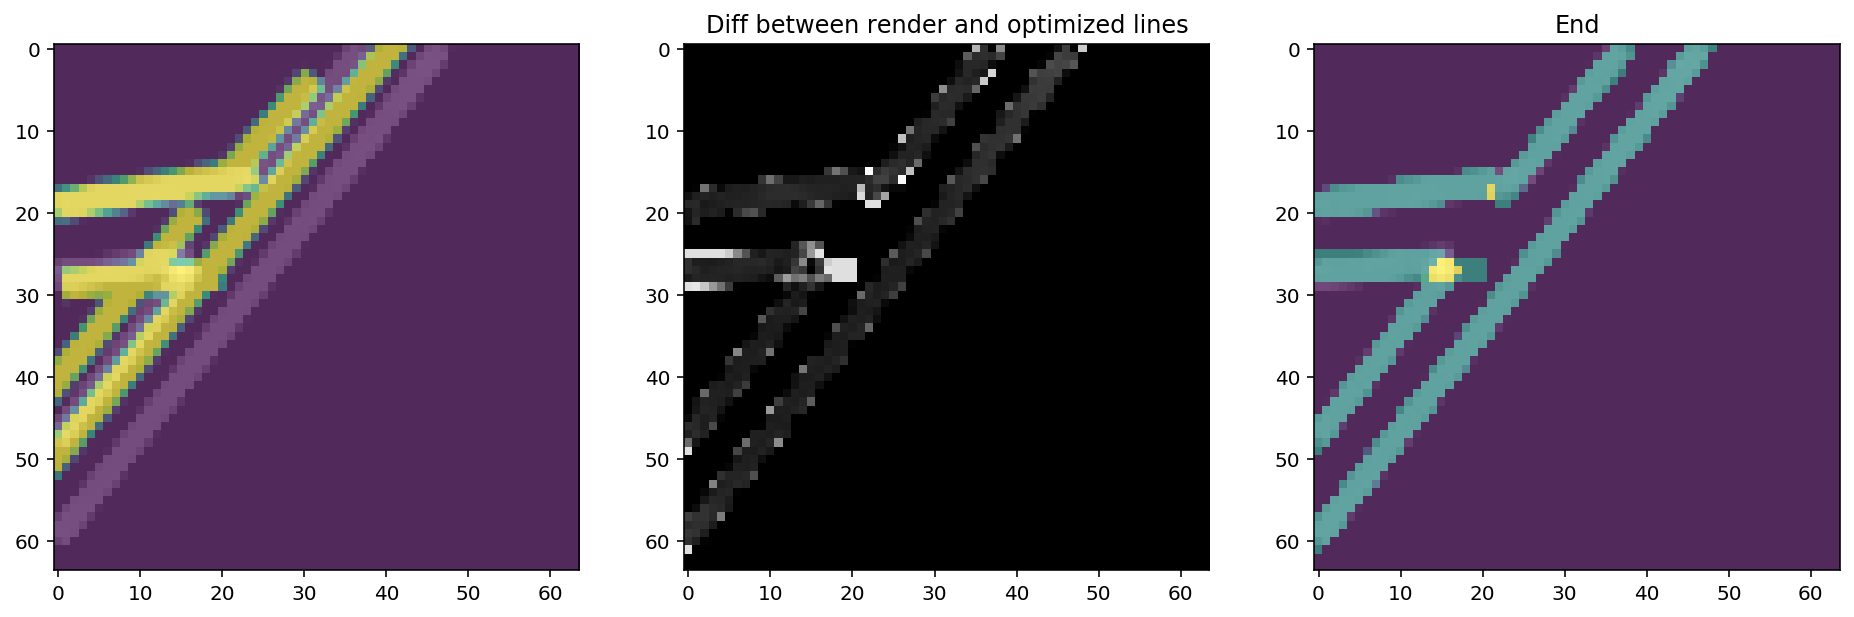

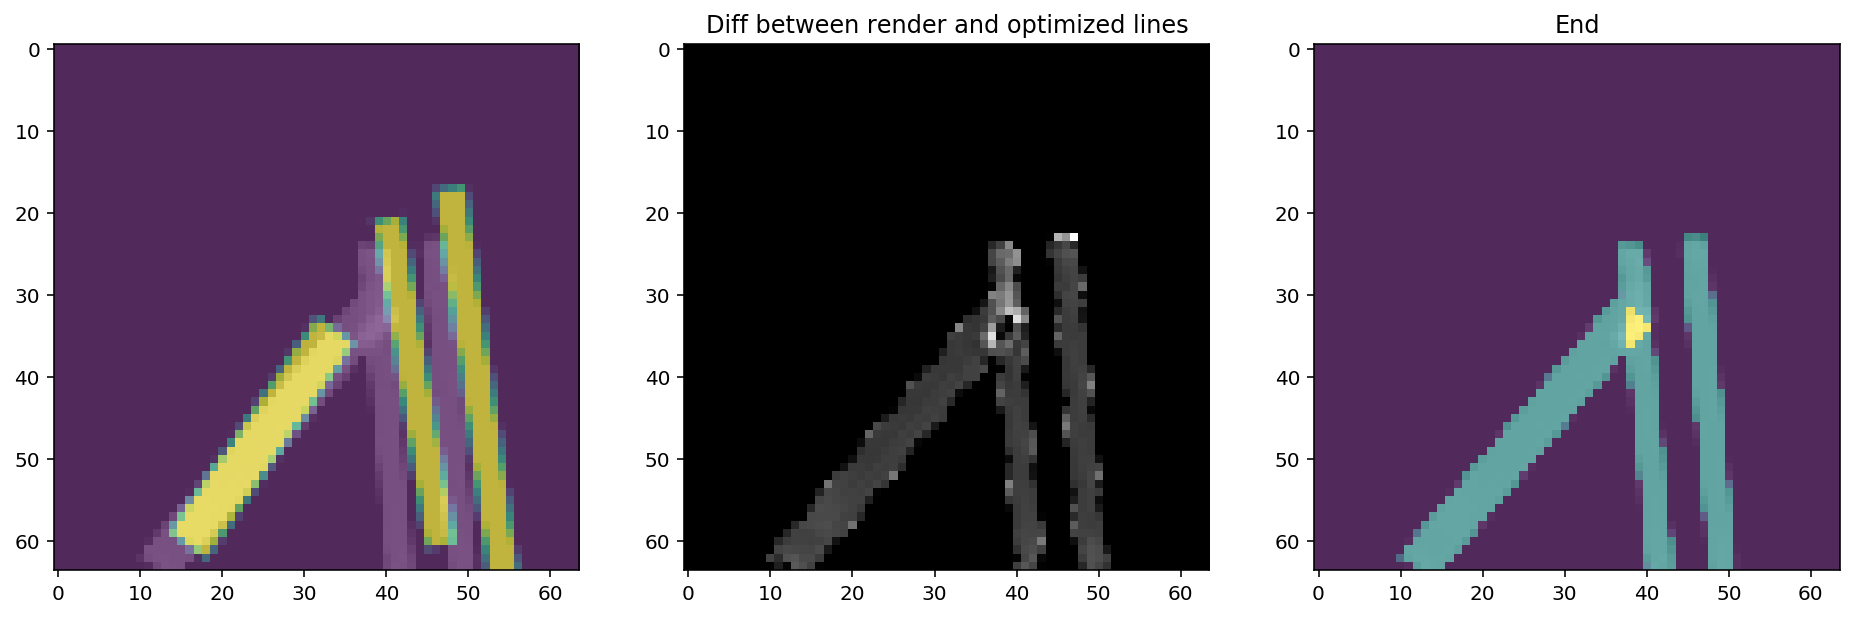

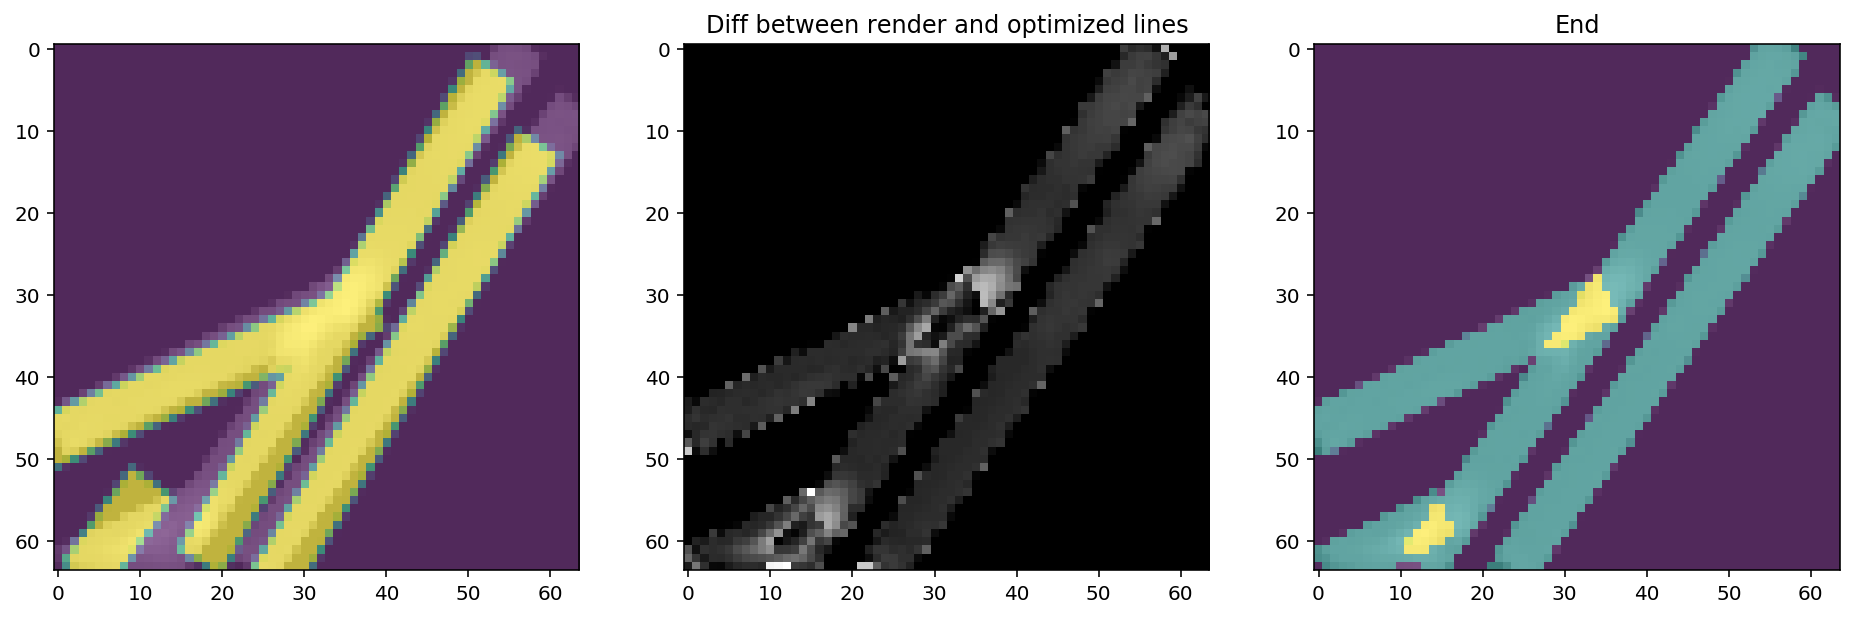

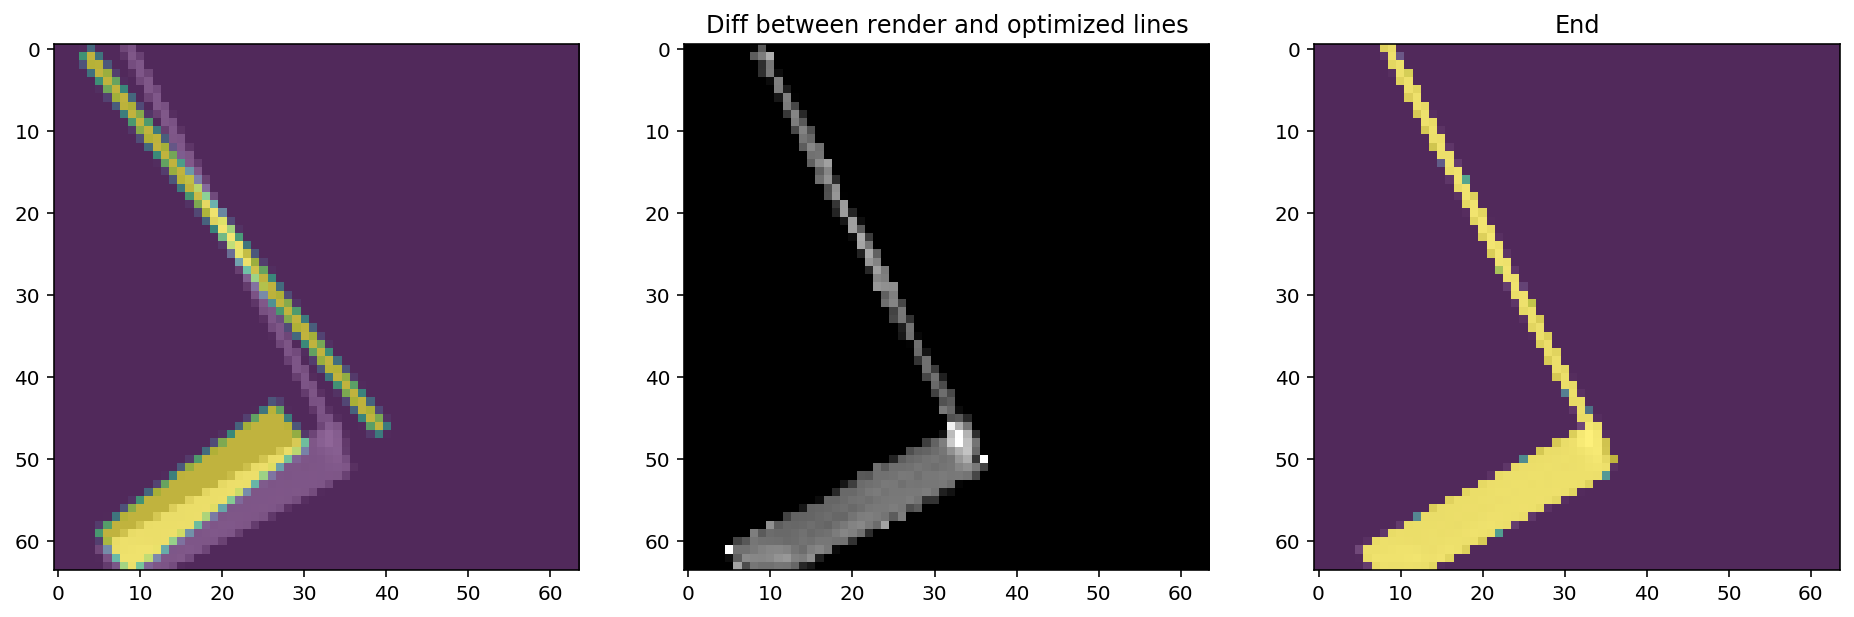

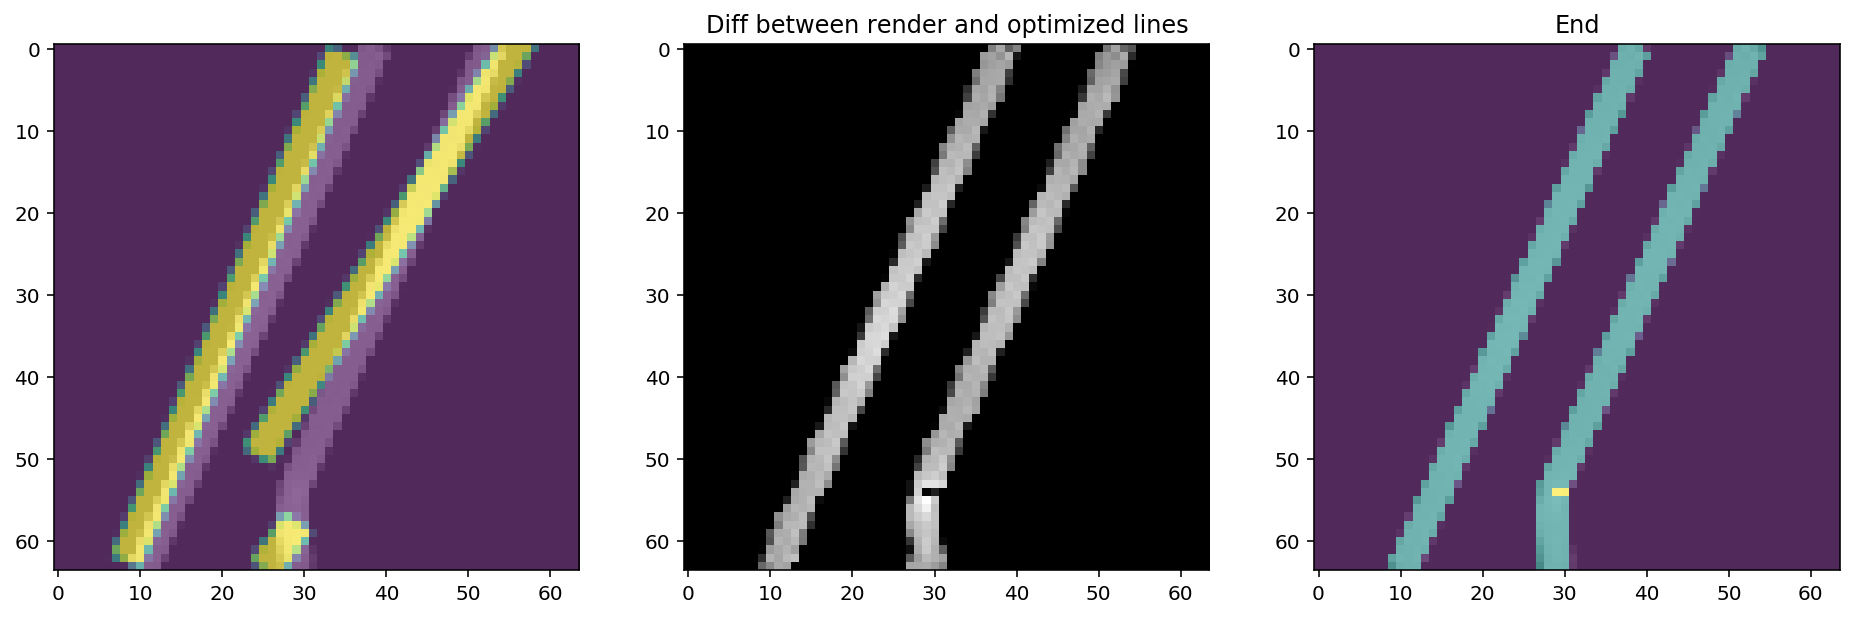

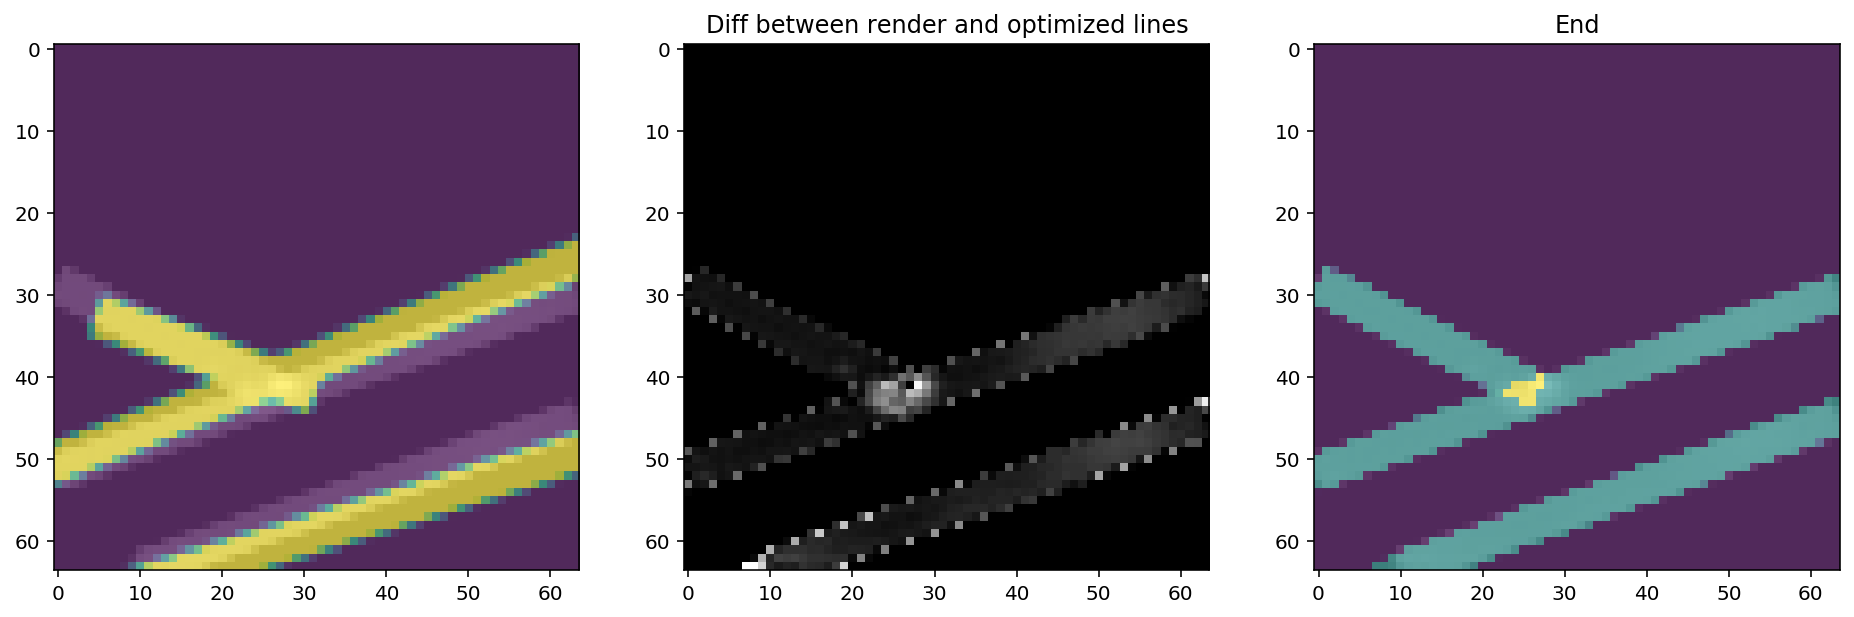

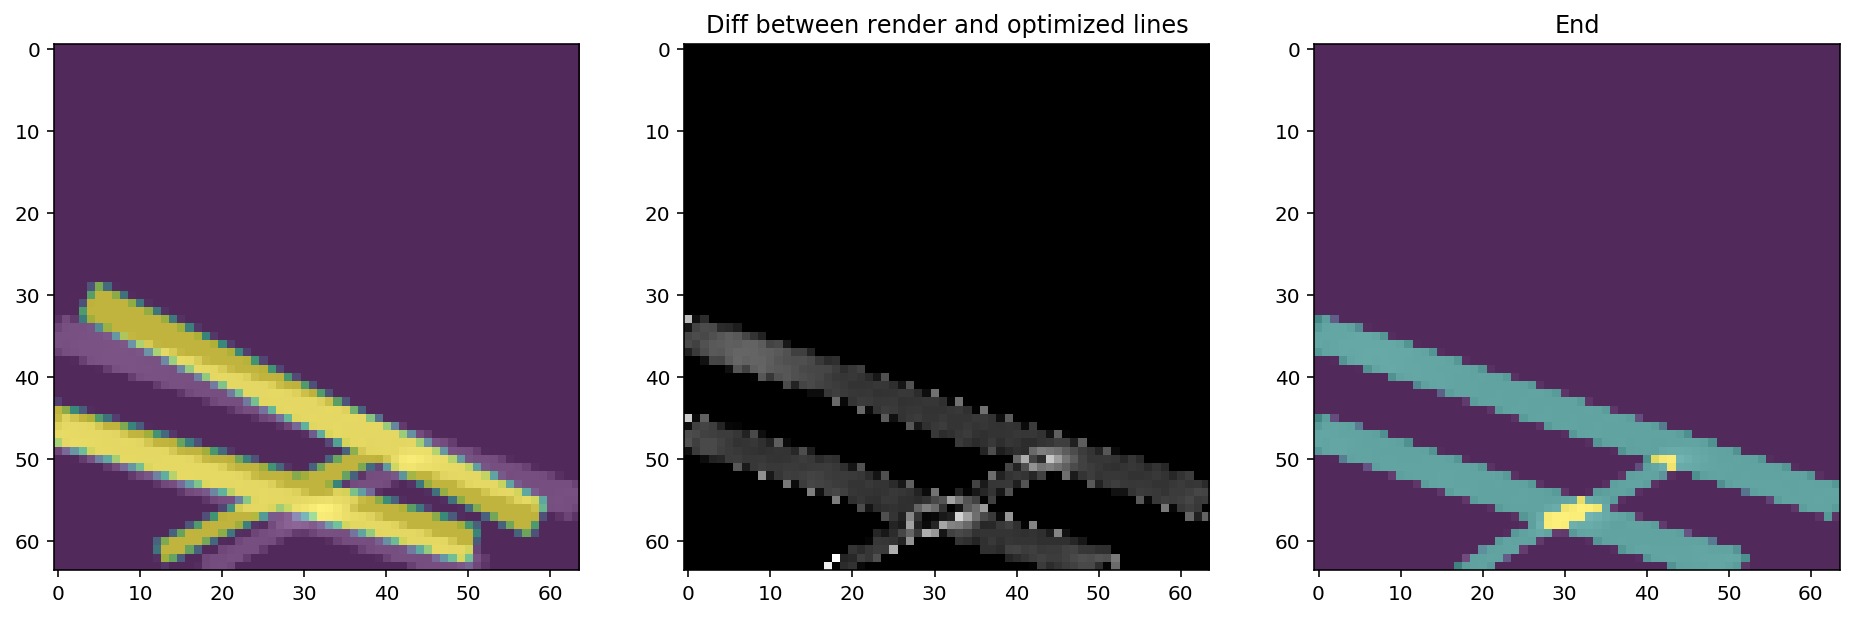

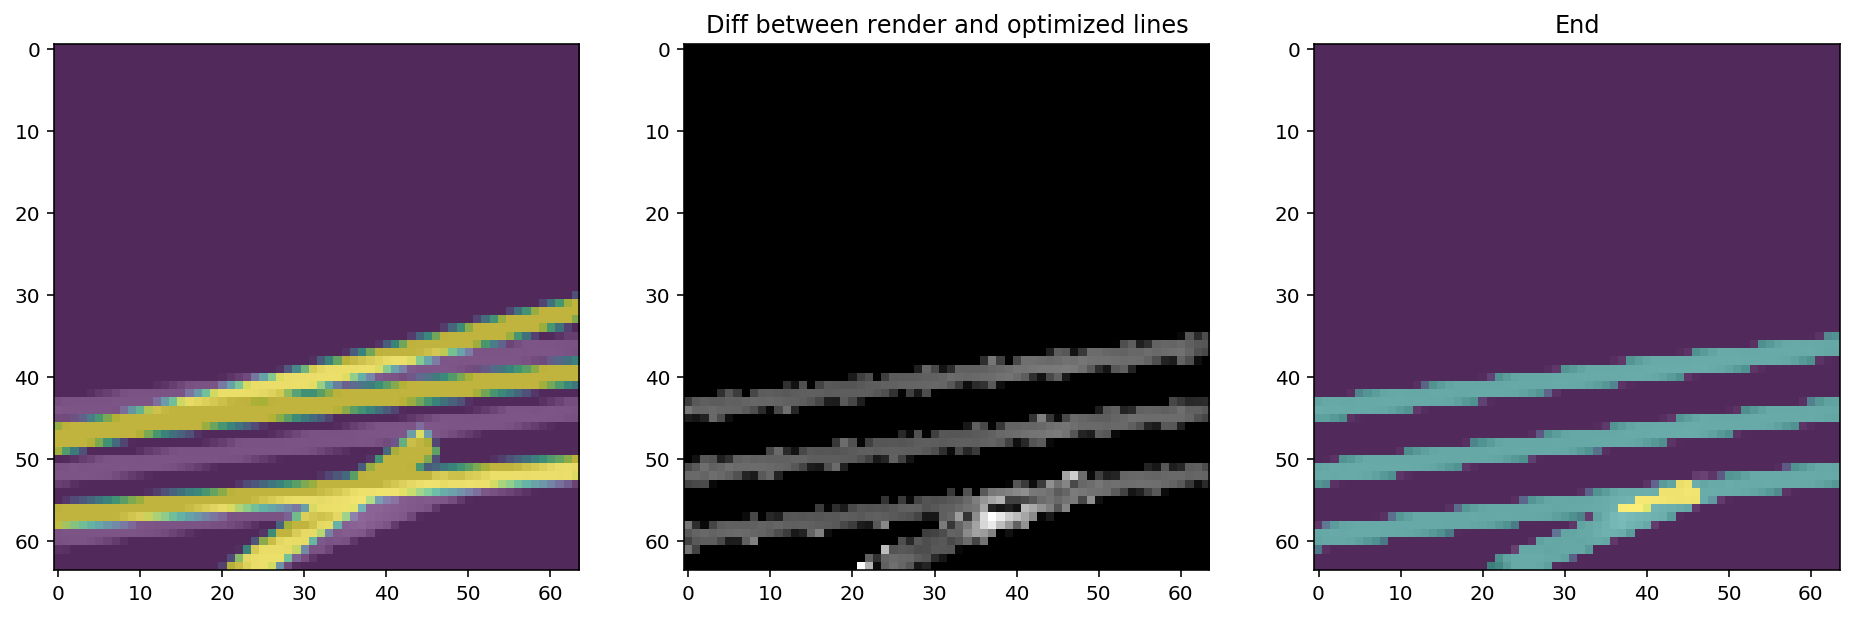

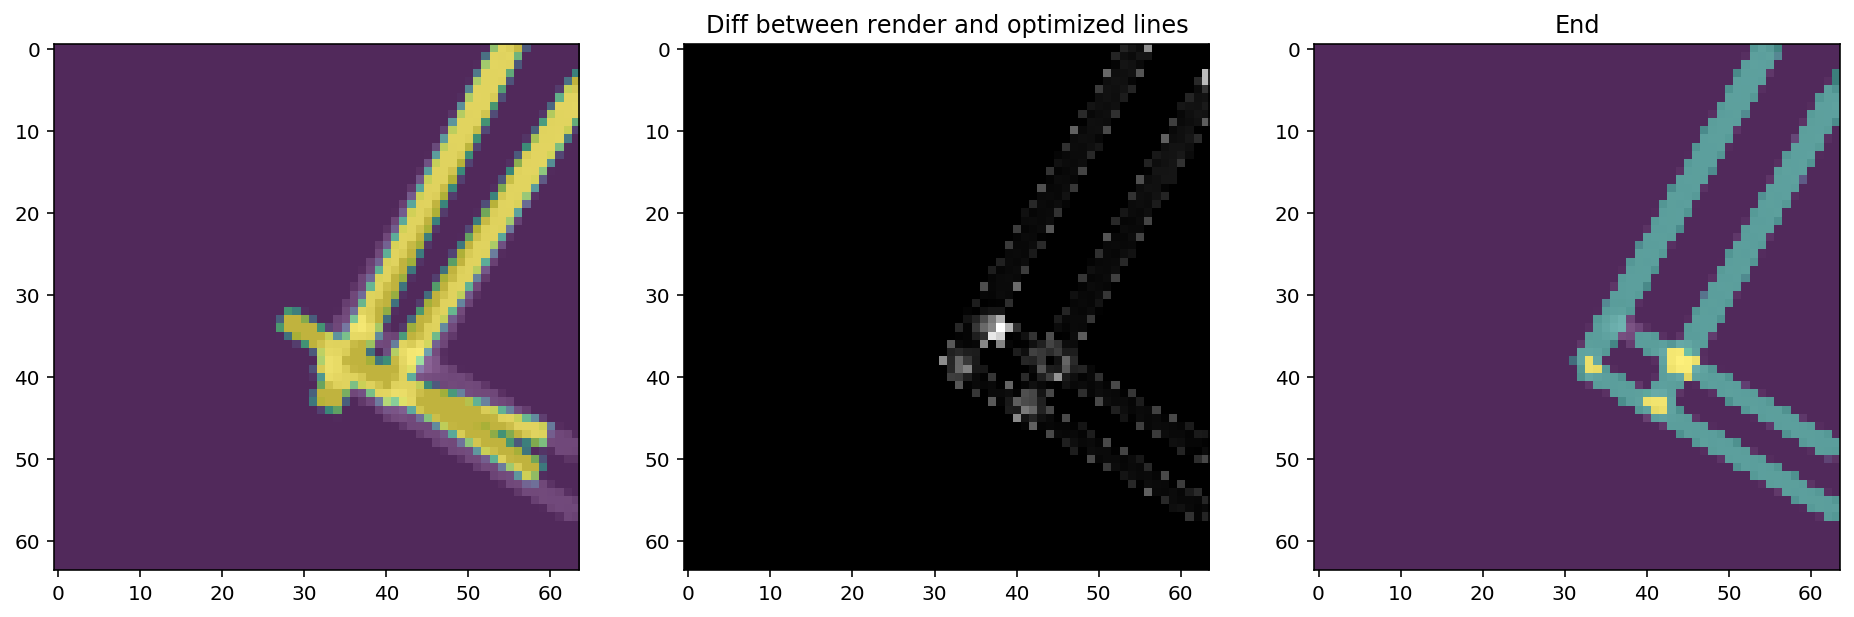

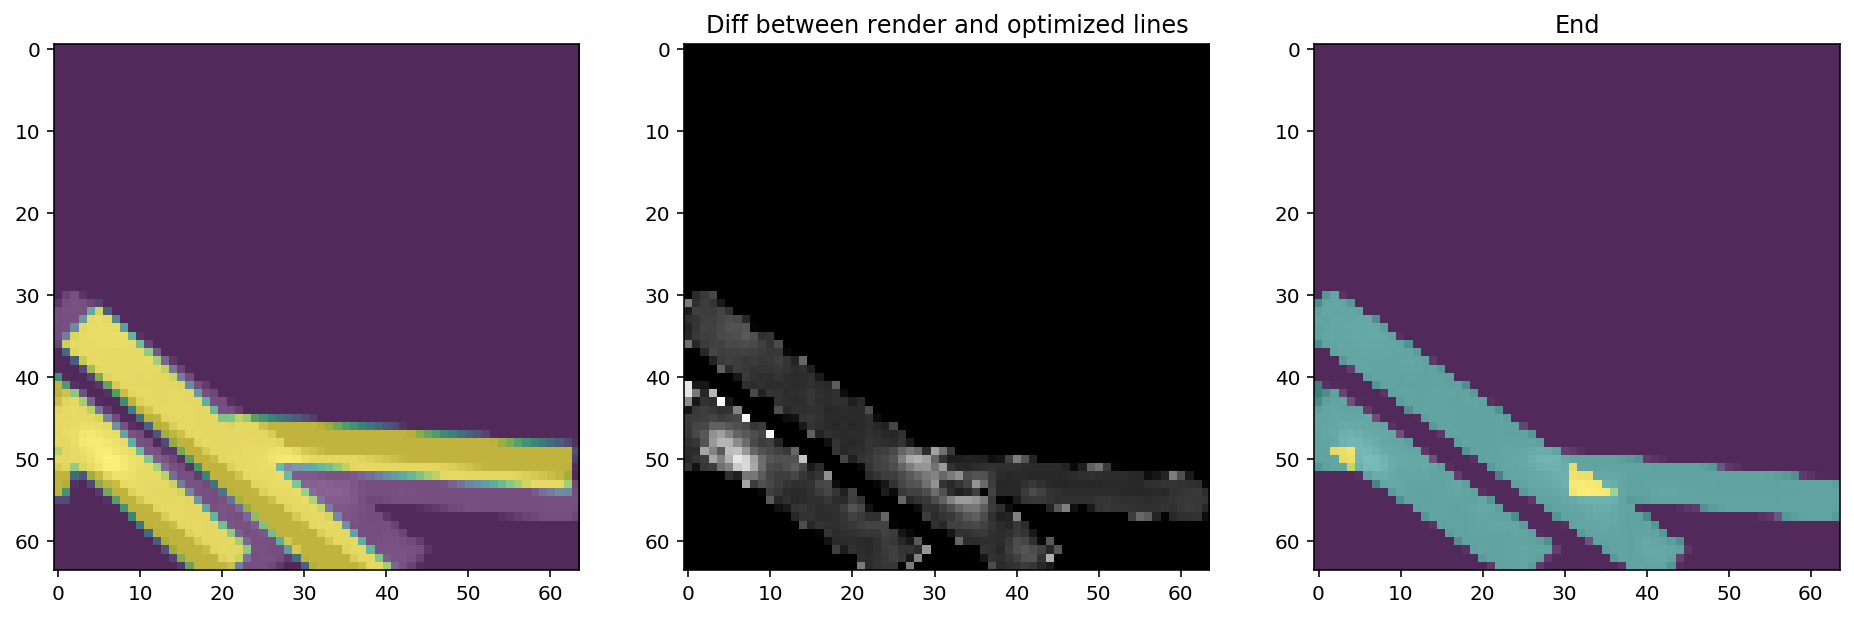

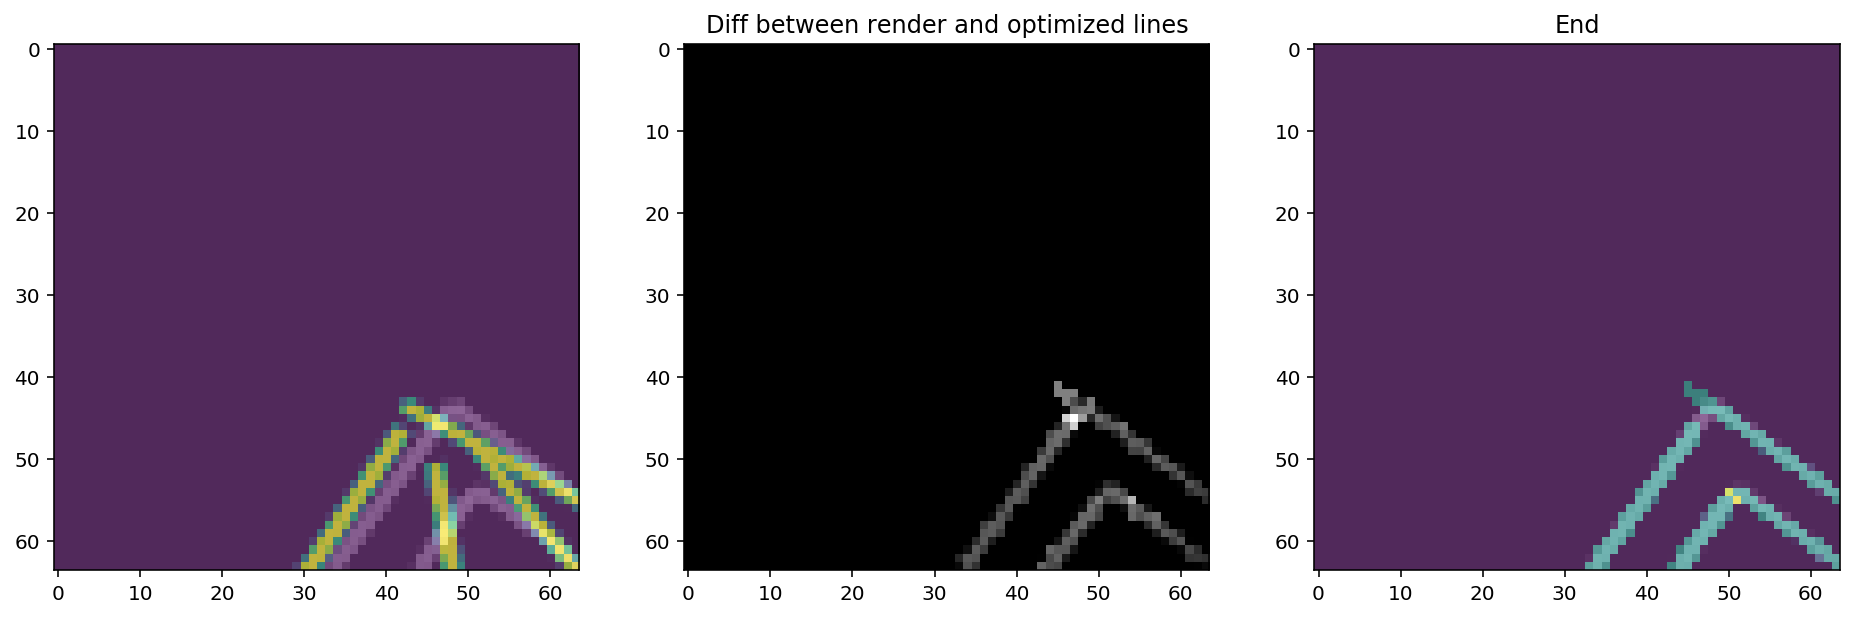

In [17]:
for i, (raster, render) in enumerate(zip(aligner.state['raster'], aligner.state['render'])):
    raster = raster.detach().cpu().numpy()
    render = render.detach().cpu().numpy()
    
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    initial = SyntheticPatch.from_lines(torch_to_synthetic_lines(aligner.state['initial_line_batch'][i].detach().cpu())).get_image()
    plt.imshow(initial, alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('Diff between render and optimized lines')
    plt.imshow(np.abs(aligner.state['difference'][i].detach().cpu().numpy()), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(raster, alpha=0.6, cmap='gray')
    plt.title('End')
    plt.imshow(aligner.state['render'][i].detach().cpu().numpy(), alpha=0.6)
    plt.show()

In [29]:
def make_animation(image, renders):
    fig = plt.figure()
    ims = []
    for i in range(len(renders)):
        background = plt.imshow(image, animated=True, alpha=0.6, cmap='gray')
        im = plt.imshow(renders[i], animated=True, alpha=0.6)
        ims.append([background, im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    
    return ani

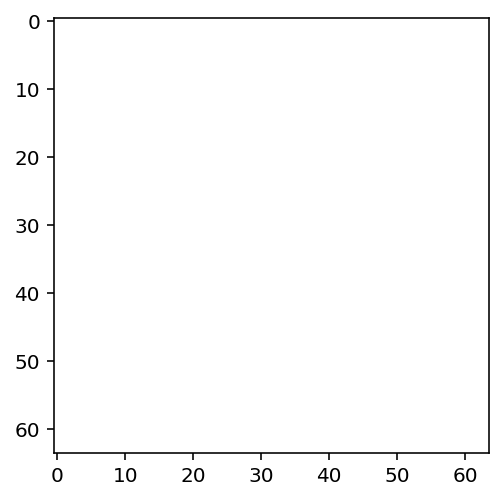

In [30]:
anim = make_animation(aligner.state['raster'][0].detach().cpu().numpy(), aligner.state['renders'])

In [31]:
HTML(anim.to_html5_video())